<a href="https://colab.research.google.com/github/ZAsaee/Image_Segmentation-GastroIntestinal_Tract_Tumor_Detection/blob/main/Notebooks/3_Image_segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Packages**

Running Colab with GPU has an issue with the TensorFlow v2.9.1, so I installed v2.8 to run the notebook using GPU. The first two lines of code should be executed before running the notebook, otherwise Colab import TensorFlow v2.9.1.

In [ ]:
!pip install tensorflow==2.8

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import shutil

import imageio
import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

random.seed(1)

In [ ]:
# Checkout if Colab connects to GPU.
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Checkout tensorflow version
tf.__version__

'2.8.0'

In [ ]:
# Authorize Google drive connection
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Open the folder
%cd /content/gdrive/My Drive/'Springboard_DS_program'/'CP3_Prj'/'Data'

/content/gdrive/My Drive/Springboard_DS_program/CP3_Prj/Data


# **2. Load and Split the Data**

## **2.1. Load the Dataset**

In [ ]:
# This folder consists of processed data
image_path = os.path.join('cleaned_data/cropped_images/')
mask_path = os.path.join('cleaned_data/cropped_masks/')

image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)

image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [ ]:
# Check out number of unmasked and masked images in each folder
print(f'number of unmasked images:{len(image_list)}')
print(f'number of masked images:{len(mask_list)}')

number of unmasked images:16590
number of masked images:16590


Let's check out some of unmasked and masked images from the dataset.

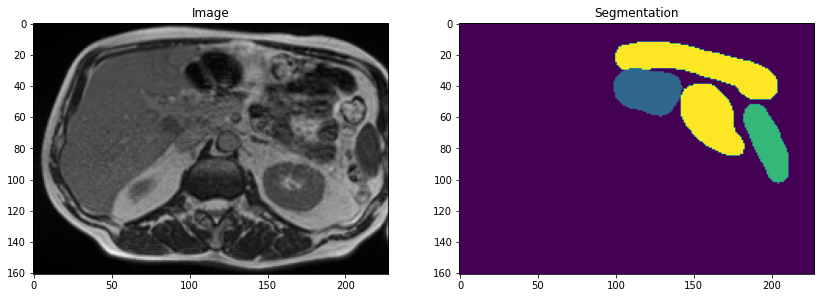

In [ ]:
N = 1600
img = cv.imread(image_list[N])
mask = cv.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14,10))
arr[0].imshow(img, cmap='gray')
arr[0].set_title('Image')
arr[1].imshow(cv.cvtColor(mask, cv.COLOR_RGB2GRAY))
arr[1].set_title('Segmentation')
plt.show()

## **2.2. Split Data to Training, Validation and Test**

In [ ]:
# Define a function to split data to train, validation and test
def split_data(IMAGE_SOURCE_DIR, MASK_SOURCE_DIR, IMAGE_TRAINING_DIR, MASK_TRAINING_DIR,
               IMAGE_VALIDATION_DIR, MASK_VALIDATION_DIR, IMAGE_TEST_DIR, MASK_TEST_DIR, 
               TRAIN_SIZE, VALID_SIZE, TEST_SIZE):
  """
  Splits the data into train, validation and test sets

  Args:
  IMAGE_SOURCE_DIR(string): directory path containing the unmasked images
  MASK_SOURCE_DIR(string): directory path containing the masked images
  IMAGE_TRAINING_DIR(string): directory path containing training unmasked images
  MASK_TRAINING_DIR(string): directory path containing training masked images
  IMAGE_TVALIDATION_DIR(string): directory path containing validation unmasked images
  MASK_TVALIDATION_DIR(string): directory path containing validation masked images
  IMAGE_TEST_DIR(string): directory path containing test unmasked images
  MASK_TEST_DIR(string): directory path containing test masked images
  TRAIN_SIZE(float): proportion of the dataset to be used for training
  VALID_SIZE(float): proportion of the dataset to be used for validation
  TEST_SIZE(float): proportion of the dataset to be used for test

  Returns: None
  """
  files = []
  for f in os.listdir(IMAGE_SOURCE_DIR):
    file_name = IMAGE_SOURCE_DIR + f
    if os.path.getsize(file_name) > 0:
      files.append(f)
    else:
      print(file_name, ' is zero size, so ignoring!')

  train_len = int(len(files) * TRAIN_SIZE)
  valid_len = int(len(files) * VALID_SIZE)
  test_len = int(len(files) * TEST_SIZE)

  shuffled_set = random.sample(files, len(files))
  train_set = shuffled_set[:train_len]
  valid_set = shuffled_set[train_len:train_len+valid_len]
  test_set = shuffled_set[train_len+valid_len:-1]

  for train_file in train_set:
    image_source_path = IMAGE_SOURCE_DIR + train_file
    mask_source_path = MASK_SOURCE_DIR + train_file
    image_target_path = IMAGE_TRAINING_DIR + train_file
    mask_target_path = MASK_TRAINING_DIR + train_file
    shutil.copyfile(image_source_path, image_target_path)
    shutil.copyfile(mask_source_path, mask_target_path)

  for valid_file in valid_set:
    image_source_path = IMAGE_SOURCE_DIR + valid_file
    mask_source_path = MASK_SOURCE_DIR + valid_file
    image_target_path = IMAGE_VALIDATION_DIR + valid_file
    mask_target_path = MASK_VALIDATION_DIR + valid_file
    shutil.copyfile(image_source_path, image_target_path)
    shutil.copyfile(mask_source_path, mask_target_path)  

  for test_file in test_set:
    image_source_path = IMAGE_SOURCE_DIR + test_file
    mask_source_path = MASK_SOURCE_DIR + test_file
    image_target_path = IMAGE_TEST_DIR + test_file
    mask_target_path = MASK_TEST_DIR + test_file
    shutil.copyfile(image_source_path, image_target_path)
    shutil.copyfile(mask_source_path, mask_target_path)

  pass

I define folders and path to those for saving training, validation and test datasets.

In [ ]:
# # Create directories to save training, validation and test unmasked and masked datasets
# !mkdir 'cleaned_data/image_training'
# !mkdir 'cleaned_data/mask_training'
# !mkdir 'cleaned_data/image_validation'
# !mkdir 'cleaned_data/mask_validation'
# !mkdir 'cleaned_data/image_test'
# !mkdir 'cleaned_data/mask_test'

In [ ]:
# Define directories paths
image_source_dir = os.path.join('cleaned_data/cropped_images/')
mask_source_dir = os.path.join('cleaned_data/cropped_masks/')

image_train_dir = os.path.join('cleaned_data/image_training/')
mask_train_dir = os.path.join('cleaned_data/mask_training/')

image_valid_dir = os.path.join('cleaned_data/image_validation/')
mask_valid_dir = os.path.join('cleaned_data/mask_validation/')

image_test_dir = os.path.join('cleaned_data/image_test/')
mask_test_dir = os.path.join('cleaned_data/mask_test/')

In [ ]:
# # Split dataset to train, validation and test
# ##split_data(image_source_dir, mask_source_dir, image_train_dir, mask_train_dir,
#                image_valid_dir, mask_valid_dir, image_test_dir, mask_test_dir, 
#                TRAIN_SIZE=0.7, VALID_SIZE=0.15, TEST_SIZE=0.15)

Let's check the number of images in each folder, and there is no mutual files between those.

In [ ]:
# List the files in each directory
image_list = os.listdir(image_source_dir)
mask_list = os.listdir(mask_source_dir)

image_train_list = os.listdir(image_train_dir)
mask_train_list = os.listdir(mask_train_dir)

image_test_list = os.listdir(image_test_dir)
mask_test_list = os.listdir(mask_test_dir)

image_valid_list = os.listdir(image_valid_dir)
mask_valid_list = os.listdir(mask_valid_dir)

image_train_list = [image_train_dir+i for i in image_train_list]
mask_train_list = [mask_train_dir+i for i in mask_train_list]

image_test_list = [image_test_dir+i for i in image_test_list]
mask_test_list = [mask_test_dir+i for i in mask_test_list]

image_valid_list = [image_valid_dir+i for i in image_valid_list]
mask_valid_list = [mask_valid_dir+i for i in mask_valid_list]


In [ ]:
# Print number of images in each directory
print(f"\n \n Original image directory has {len(image_list)} images")
print(f"Original mask disrectory has {len(mask_list)} masked images \n")

print(f"There are {len(image_train_list)} unmasked images and {len(mask_train_list)} masked images for training")
print(f"There are {len(image_valid_list)} unmasked images and {len(mask_valid_list)} masked images for validation")
print(f"There are {len(image_test_list)} unmasked images and {len(mask_test_list)} masked images for test")


 
 Original image directory has 16590 images
Original mask disrectory has 16590 masked images 

There are 11613 unmasked images and 11613 masked images for training
There are 2488 unmasked images and 2488 masked images for validation
There are 2488 unmasked images and 2488 masked images for test


In [ ]:
print(image_train_list[:3])
print(mask_train_list[:3])
print(image_test_list[:3])
print(mask_test_list[:3])
print(image_valid_list[:3])
print(mask_valid_list[:3])

['cleaned_data/image_training/case7_day13_slice_0071.png', 'cleaned_data/image_training/case33_day0_slice_0121.png', 'cleaned_data/image_training/case34_day16_slice_0029.png']
['cleaned_data/mask_training/case7_day13_slice_0071.png', 'cleaned_data/mask_training/case33_day0_slice_0121.png', 'cleaned_data/mask_training/case34_day16_slice_0029.png']
['cleaned_data/image_test/case89_day19_slice_0085.png', 'cleaned_data/image_test/case144_day0_slice_0066.png', 'cleaned_data/image_test/case89_day20_slice_0084.png']
['cleaned_data/mask_test/case89_day19_slice_0085.png', 'cleaned_data/mask_test/case144_day0_slice_0066.png', 'cleaned_data/mask_test/case89_day20_slice_0084.png']
['cleaned_data/image_validation/case142_day14_slice_0077.png', 'cleaned_data/image_validation/case41_day25_slice_0086.png', 'cleaned_data/image_validation/case81_day28_slice_0090.png']
['cleaned_data/mask_validation/case142_day14_slice_0077.png', 'cleaned_data/mask_validation/case41_day25_slice_0086.png', 'cleaned_data/m

There is no overlap between files in three datasets.

In [ ]:
# Check out if there is any duplicate in three categories
print([i for i in image_train_list if i in image_valid_list])
print([i for i in image_test_list if i in image_train_list])
print([i for i in image_test_list if i in image_valid_list])

print([i for i in mask_test_list if i in mask_train_list])
print([i for i in mask_test_list if i in mask_train_list])
print([i for i in mask_test_list if i in mask_valid_list])

[]
[]
[]
[]
[]
[]


# **3. Prepare the Dataset**

I define the folder paths to create the inputs for the UNet model.

In [ ]:
# Create tensorslice dataset from the datasets
train_image_list_ds = tf.data.Dataset.list_files(image_train_list, shuffle=False)
train_mask_list_ds = tf.data.Dataset.list_files(mask_train_list, shuffle=False)

validation_image_list_ds = tf.data.Dataset.list_files(image_valid_list, shuffle=False)
validation_mask_list_ds = tf.data.Dataset.list_files(mask_valid_list, shuffle=False)

test_image_list_ds = tf.data.Dataset.list_files(image_test_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(mask_test_list, shuffle=False)

Now, the umasked and masked images are zipped together to feed to the UNet model.

In [ ]:
for path in zip(train_image_list_ds.take(5), train_mask_list_ds.take(5)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0066.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_training/case101_day20_slice_0066.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0067.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_training/case101_day20_slice_0067.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0069.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_training/case101_day20_slice_0069.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0070.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_training/case101_day20_slice_0070.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_training/case101_day20_slice_0072.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_t

In [ ]:
for path in zip(test_image_list_ds.take(5), test_mask_list_ds.take(5)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0071.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0071.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0083.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0083.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0089.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0089.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0093.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0093.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/image_test/case101_day20_slice_0095.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'cleaned_data/mask_test/case101_day20_slice_0095.png'>)


In [ ]:
# Create a slice dataset 
train_image_filenames = tf.constant(image_train_list)
train_mask_filenames = tf.constant(mask_train_list)
train = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_mask_filenames))

test_image_filenames = tf.constant(image_test_list)
test_mask_filenames = tf.constant(mask_test_list)
test = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_mask_filenames))

validation_image_filenames = tf.constant(image_valid_list)
validation_mask_filenames = tf.constant(mask_valid_list)
validation = tf.data.Dataset.from_tensor_slices((validation_image_filenames, validation_mask_filenames))

for image, mask in train.take(1):
  print(image)
  print(mask)

for image, mask in test.take(1):
  print(image)
  print(mask)

for image, mask in validation.take(1):
  print(image)
  print(mask)

tf.Tensor(b'cleaned_data/image_training/case7_day13_slice_0071.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/mask_training/case7_day13_slice_0071.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/image_test/case89_day19_slice_0085.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/mask_test/case89_day19_slice_0085.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/image_validation/case142_day14_slice_0077.png', shape=(), dtype=string)
tf.Tensor(b'cleaned_data/mask_validation/case142_day14_slice_0077.png', shape=(), dtype=string)


## **3.1. Normalize and Resize the Unmasked and Masked Images**

I will now prepare the train, validation and test sets through the following steps:
- normalizing the pixel values
- resizing the images

By using tf.image.convert_image_dtype with tf.float32, we normalize the pixel values and set them between 0 and 1.

In [ ]:
# Create functions to normalize and resize the non-masked and masked images
def normalize(image_path, mask_path):
  '''
  normalizes the input image pixel values to be from [0,1] and
  mask image pixel values to be integer and from [0,3]

  image_path: the path to the non-masked images folder
  mask_path: the path to the masked images folder

  return the normalized non-masked image and corresponding non-masked image as tensors
  '''

  img = tf.io.read_file(image_path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img = tf.cast(img, tf.float32) / 255.0

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=3)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
  mask = tf.cast(tf.image.convert_image_dtype(mask, tf.float32)*3, tf.int16)
  
  return img, mask

def resize(image, mask):
  '''
  resizes the unmasked and masked images to (96, 128)

  image: unmasked image
  mask: masked image
  '''
  input_image = tf.image.resize(image, (96, 128), method='nearest')
  input_mask = tf.image.resize(mask, (96, 128), method='nearest')

  return input_image, input_mask

In [ ]:
# Normalize and resize the train, validation and test dataset
train_ds = train.map(normalize)
train_processed_ds = train_ds.map(resize)

validation_ds = validation.map(normalize)
validation_processed_ds = validation_ds.map(resize)

test_ds = test.map(normalize)
test_processed_ds = test_ds.map(resize)

Let's check out the images after resizing and normalizing operations.

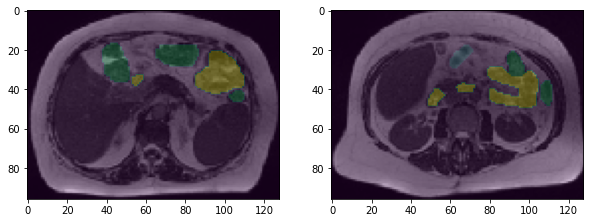

In [ ]:
plt.figure(figsize=(10,16))
n = 1
for i, j in validation_processed_ds.take(2):
  plt.subplot(4,2,n)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(i))
  n += 1
  plt.imshow(tf.keras.preprocessing.image.array_to_img(j), alpha=0.3)
  # plt.colorbar()

plt.show()

# **4. U-Net Model**

## **4.1. U-Net Architecture Details**

U-Net architecture (named for its U-shape as shown below) was originally introduced in 2015 for the tumor detection research, and after a while has become a very popular choice for image segmentation tasks. U-Net architecture is based on the Fully Conventional Network (FCN). This architecture replaces the dense layers (usually part of a typical CNN) with a transposed convolution layer to upsample the feature map back to the size of original input image, while preserving the spatial information. This is an essential characteristic of the U-Net for image segmentation, since the dense layers destroy spatial information. The main issue with FCN is that its final feature layer suffers from information loss due to too much downsampling. Therefore, it becomes difficult to upsample after losing so much information and causing an output that looks rough. 

U-Net addressed the FCN issue using a similar design but with some important modifications. Instead of one transposed convolution at the end of the network, U-Net uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original inut image size. U-Net also adds skip connections between downsampling and upsampling blocks to retain information and avoid losing information during encoding. Skip connections send information from the downsampling layer in encoder to the upsampling layers in decoder. These skip connections capture finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

The images are fed through several convolution layers to reduce height and width, while increasing their channels. A U-Net consists of encoder (downsampler) and decoder (upsampler) with a bottleneck in between. 

**U-NET Architecture**

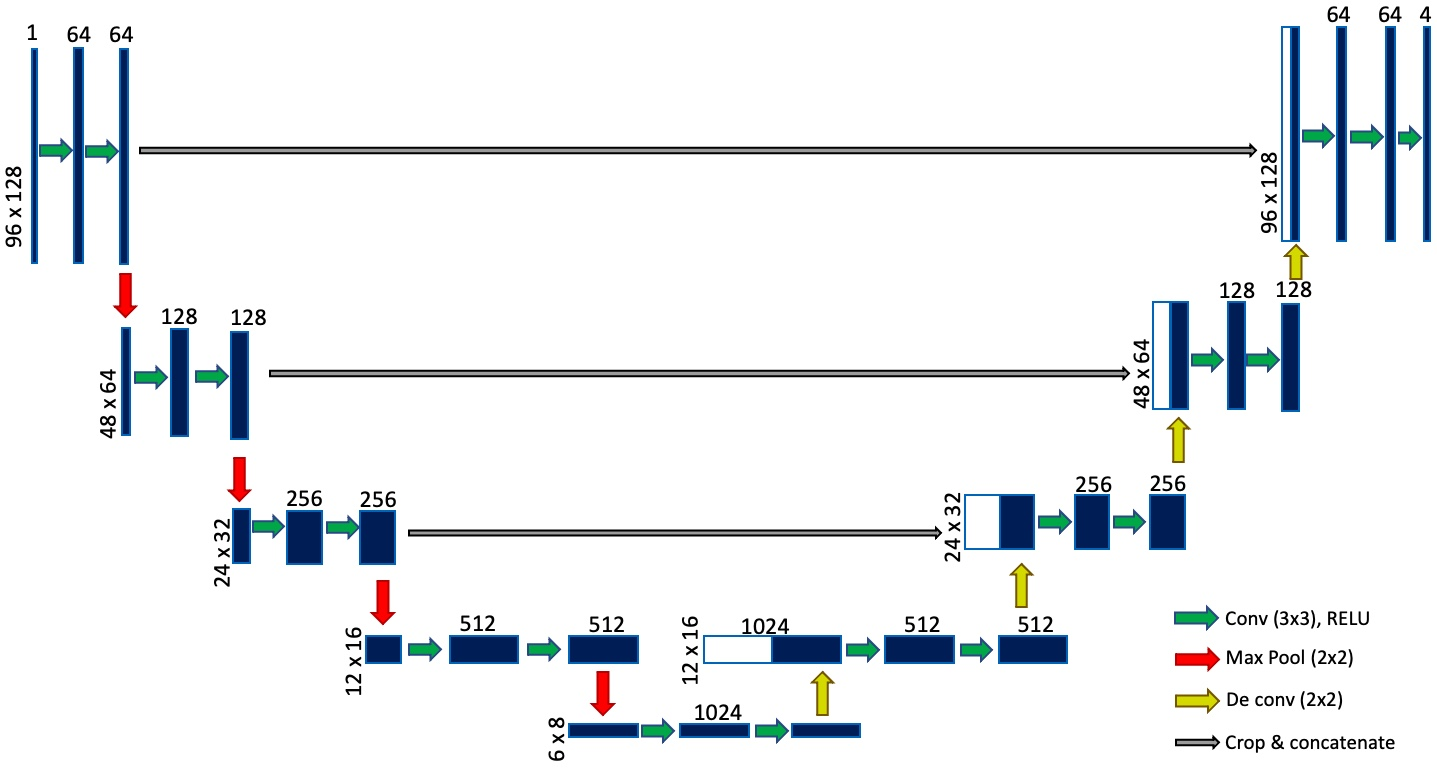

## **4.1. Downsampling Blocks (Encoder)**

The downsampling blocks (encoder) follow a regular CNN architecture including convolutional layers followed by their activation, max pooling layers to downsample the image and extract features. Each block consists of two 3x3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. The number of feature channels are doubled at each step. At each step of encoder, a skip connection is created by cropping the image from the downsampling path and concatenates it to the current image on the upsampling path.



**Downsampling Block - U-NET**

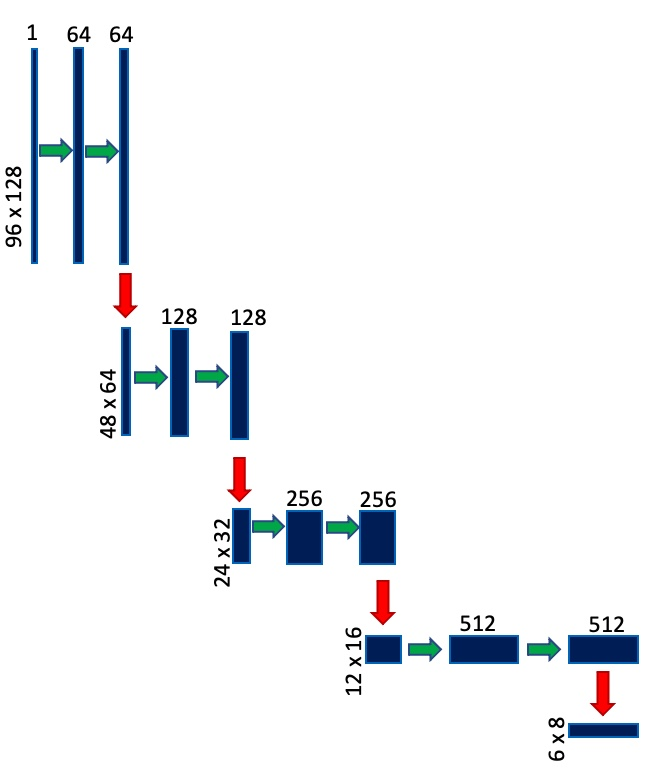

I define three functions to create the encoder path:



*   downsampling_block(): two convolutional layers with ReLU activation functions followed with pooling and dropout layers. The output of this function is two parameters including the output of the dropout as the input of next block, and the output of conv2d block for the skip connection.
* downsample(): put it together and build the whole encoder path



In [ ]:
# Encoder Part

def downsampling_block(input_layer, n_filters, kernel_size=3, pool_size=(2,2), dropout=0.3):
  '''
  Adds 2 convolutional layers followed by a maxpooling and dropout 
  with the parameters passed to it

  input_layer: the input tensor
  n_filters: number of filters
  kernel size: kernel size for convolution layers
  pool_size: size of maxpooled filter
  dropout: dropout ratio

  Return:
  conv_out: the output of convolution block in order to implement in the upsampling path
  block_out: the output of maxpooled and dropout layers
  '''
  # first layer
  conv_out = input_layer
  for i in range(2):
    conv_out = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                               kernel_initializer = 'he_normal', padding = 'same')(conv_out)
    conv_out = tf.keras.layers.Activation('relu')(conv_out)

  block_out = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_out)
  block_out = tf.keras.layers.Dropout(0.3)(block_out)

  return conv_out, block_out

def downsample(inputs):
  '''
  defines the downsampling path

  inputs: batch of input images

  return:
  block_out4: the output of maxpooled features of the last encoder block
  (conv_out1, conv_out2, conv_out3, conv_out4): the output features of all encoder blocks
  '''

  conv_out1, block_out1 = downsampling_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  conv_out2, block_out2 = downsampling_block(block_out1, n_filters=128, pool_size=(2,2), dropout=0.3)
  conv_out3, block_out3 = downsampling_block(block_out2, n_filters=256, pool_size=(2,2), dropout=0.3)
  conv_out4, block_out4 = downsampling_block(block_out3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return block_out4, (conv_out1, conv_out2, conv_out3, conv_out4)

## **4.2. Bottleneck Block**

A bottleneck path follows the encoder block and its main purpose is to extract more features. The bottleneck path does not include any max pooling layer, therefore the dimensionality remains the same. conv2d_block can be used to implement this path.

**Bottleneck Block**

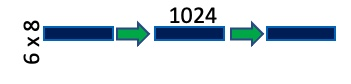

In [ ]:
def bottleneck(inputs, n_filters=1024, kernel_size=3):
  '''
  defins the bottleneck convolution to extract more features before the upsampling layers
  '''
  bottle_neck = inputs
  for i in range(2):
    bottle_neck = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                               kernel_initializer = 'he_normal', padding = 'same')(bottle_neck)
    bottle_neck = tf.keras.layers.Activation('relu')(bottle_neck)
  
  return bottle_neck

## **4.3. Decore Block (Upsampling)**

The upsampling path performs opposite of the downsampling path and grows the image back to its original size while shrinking the channels gradually. In the upsampling path, the output of the corresponding encoder block is concatenated before feeding to the next encoer block. The encoder path consists of two main components of transpose convolution and skip connections

**Upsampling Block - U-NET**

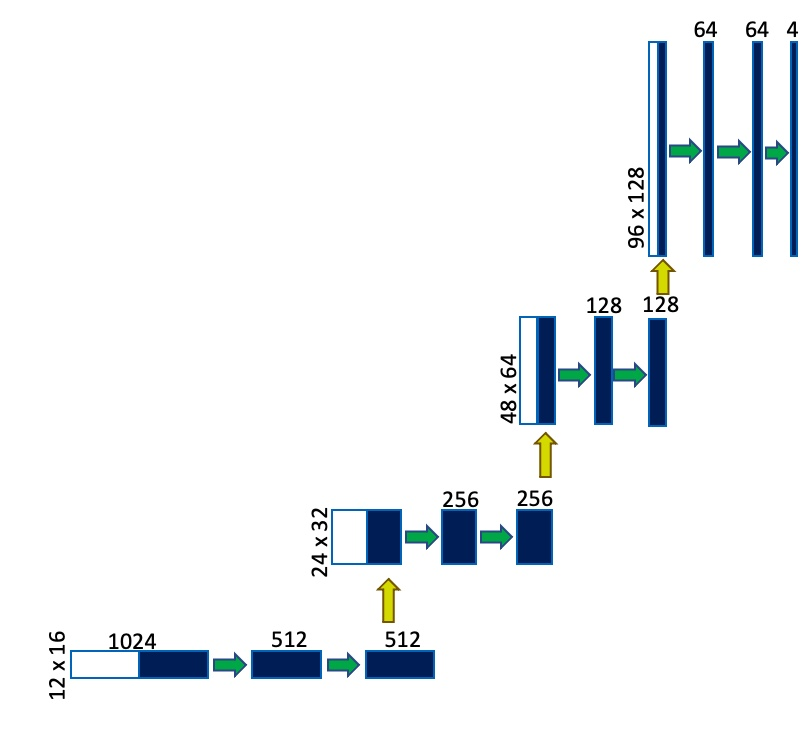

In [ ]:
# Decoder Part

def upsampling_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  define the upsampling block of the UNet

  inputs: batch of input features
  conv_output: features from a downsampling block
  n_filters: number of filters
  kernel_size: kernel size
  strides: strides for deconvolution/upsampling
  padding: "same" or "valid"

  return:
  c: output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=strides, padding='same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  for i in range(2):
    c = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                               kernel_initializer = 'he_normal', padding = 'same')(c)
    c = tf.keras.layers.Activation('relu')(c)
  
  return c

def upsample(inputs, convs, output_channels):
  '''
  define the decoder of UNet containing four decoder blocks

  inputs: batch of input features
  convs: features from the encoder blocks
  ouput_channels: number of classes in the label map

  return:
  outputs: the pixel wise label map of the image

  '''

  f1, f2, f3, f4 = convs

  c6 = upsampling_block(inputs, f4, n_filters=512, kernel_size=3, strides=(2,2), dropout=0.3)
  c7 = upsampling_block(c6, f3, n_filters=256, kernel_size=3, strides=(2,2), dropout=0.3)
  c8 = upsampling_block(c7, f2, n_filters=128, kernel_size=3, strides=(2,2), dropout=0.3)
  c9 = upsampling_block(c8, f1, n_filters=64, kernel_size=3, strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1,1), padding='same', activation='softmax')(c9)

  return outputs


## **4.4. Build the U-Net Model**

I create the U-Net model by putting it all together, and chaining the encoder, bottleneck and decoder.

In [ ]:
# number of output channels are equal to the number of classes
OUTPUT_CLASSES = 4

def unet():
  '''
  connect encoder, bottleneck and decoder to form UNet
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(96,128,3))

  # feed the inputs to the encoder
  encoder_ouput, convs = downsample(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_ouput)

  # feed the bottleneck and encoder outputs to the decoder
  outputs = upsample(bottle_neck, convs, output_channels=OUTPUT_CLASSES)

  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [ ]:
# instantiate the model
model = unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 96, 128, 64)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 64)  36928       ['activation[0][0]']         

## **4.5. Compile and Train the Model**

In [ ]:
# define the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# STEPS_PER_EPOCH = len(image_train_list) // BATCH_SIZE
# VALIDATION_STEPS = len(image_valid_list) // BATCH_SIZE // VAL_SUBSPLITS

# shuffle and group the train set to batches
train_dataset = train_processed_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the validation set to batches
validation_dataset = validation_processed_ds.batch(BATCH_SIZE)

In [ ]:
# set the callback to stop training the model when reached 99% accuracy

class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') is not None and logs.get('accuracy') > 0.99):
                print("\nReached 99% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [ ]:
# fit the model
callbacks = myCallback()

with tf.device('/gpu:0'):
  model_history = model.fit(train_dataset, epochs=EPOCHS,
                          # steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          validation_data=validation_dataset,
                          callbacks=callbacks)


Epoch 1/20
363/363 [==============================] - 1036s 2s/step - loss: 0.2477 - accuracy: 0.9355 - val_loss: 0.1719 - val_accuracy: 0.9417
Epoch 2/20
363/363 [==============================] - 72s 199ms/step - loss: 0.1268 - accuracy: 0.9527 - val_loss: 0.1000 - val_accuracy: 0.9620
Epoch 3/20
363/363 [==============================] - 72s 199ms/step - loss: 0.0953 - accuracy: 0.9637 - val_loss: 0.0828 - val_accuracy: 0.9676
Epoch 4/20
363/363 [==============================] - 72s 199ms/step - loss: 0.0791 - accuracy: 0.9699 - val_loss: 0.0672 - val_accuracy: 0.9743
Epoch 5/20
363/363 [==============================] - 72s 199ms/step - loss: 0.0703 - accuracy: 0.9733 - val_loss: 0.0627 - val_accuracy: 0.9762
Epoch 6/20
363/363 [==============================] - 72s 199ms/step - loss: 0.0628 - accuracy: 0.9760 - val_loss: 0.0571 - val_accuracy: 0.9784
Epoch 7/20
363/363 [==============================] - 72s 199ms/step - loss: 0.0585 - accuracy: 0.9777 - val_loss: 0.0521 - val_acc

In [ ]:
# ## create a directory to save the model
# !mkdir '/content/gdrive/MyDrive/Springboard_DS_program/CP3_Prj/Model/unet_rev2'

In [ ]:
# ## save the model
# model.save('/content/gdrive/MyDrive/Springboard_DS_program/CP3_Prj/Model/unet_rev2/')

## **4.6. Plot the Model Accuracy**

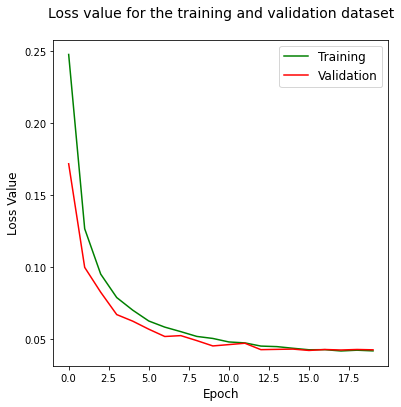

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(model_history.history["loss"], color='g', label='Training')
plt.plot(model_history.history["val_loss"], color='r', label='Validation')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title('Loss value for the training and validation dataset', y=1.05, fontsize=14)
plt.legend(fontsize=12)
plt.show()

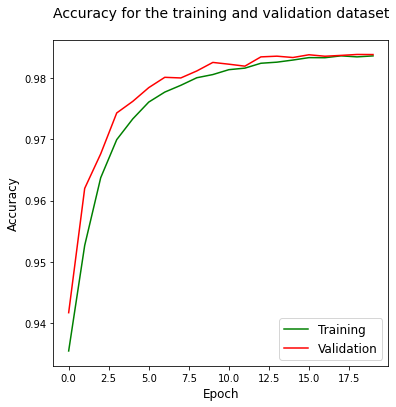

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(model_history.history["accuracy"], color='g', label='Training')
plt.plot(model_history.history["val_accuracy"], color='r', label='Validation')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy for the training and validation dataset', y=1.05, fontsize=14)
plt.legend(fontsize=12)
plt.show()

## **4.7. Make Predictions**

I feed the test dataset into the model and predict the mask of images. In order to do it, I define some functions for prediction and displaying it.

In [ ]:
def create_mask(pred_mask):
  '''
  creates the segmentation mask by getting the channel with the highest probability. 
  I have four channels in the output of U-Net. 
  The prediction of each pixel is the channel with the highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(model, image):
  '''
  inputs an image to the model and predicts the mask
  '''
  image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

## **4.8. Compute Prediction Metrics**

I use Intersection of Union (IOU) and Dice Score to evaluate the prediction.

\begin{align}
    IOU = \frac{Area \, of \, overlap}{Area \, of \, union}
\end{align}


\begin{align}
    Dice Score = IOU = \frac{2 * Area \, of \, overlap}{Total \, area \, of \, both \, images}
\end{align}
  


In [ ]:
def class_metrics(y_true, y_pred, n_classes):
  class_iou = []
  class_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    if (y_true_area == 0 and y_pred_area == 0):
      iou = (intersection + smoothing_factor) / (combined_area - intersection + smoothing_factor)
      class_iou.append(iou)

      dice_score = (intersection + smoothing_factor) / (combined_area + smoothing_factor)
      class_dice_score.append(dice_score)
    else:
      iou = intersection / (combined_area - intersection + smoothing_factor)
      class_iou.append(iou)

      dice_score = 2 * intersection / (combined_area + smoothing_factor)
      class_dice_score.append(dice_score)

  return class_iou, class_dice_score

def metrics_eval(dataset):
  n = len(list(dataset))
  iou_score = []
  dice_score = []
  for image, true_mask in dataset.take(n):
    results = model.predict(np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2])))
    results = np.argmax(results, axis=3)
    results = results[..., tf.newaxis]
    iou, dice = class_metrics(true_mask.numpy(), results, 4)
    
    iou_score.append(iou)
    dice_score.append(dice)

  avg_iou = []
  avg_dice = []

  for label in range(4):
    avg_iou.append(sum([iou_score[i][label] for i in range(len(iou_score))])/len(iou_score))
    avg_dice.append(sum([dice_score[i][label] for i in range(len(dice_score))])/len(dice_score))  
  
  return iou_score, dice_score, avg_iou, avg_dice

In [ ]:
def display(dataset, num):
  '''
  plots the image, ground truth mask and predicted mask.
  display_list consists of input image, true mask and predicted mask
  '''
  for image, mask in dataset.take(num):
    image = image
    true_mask = mask
  display_list = [image, true_mask, make_predictions(model, image)]
  plt.figure(figsize=(15, 15))
  label = ['Stomach', 'Large Bowel', 'Small Bowel']

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  dice = metrics_eval(dataset.take(num))[1][-1]
  iou =  metrics_eval(dataset.take(num))[0][-1]

  string = '\n' + label[0]+' -- '+ 'dice score: ' + str(np.round(dice[1],4)) + ' /// ' + 'IOU score: ' + str(np.round(iou[1],4)) + ' \n \n' + \
           label[1]+' -- '+ 'dice score: ' + str(np.round(dice[2],4)) + ' /// ' + 'IOU score: ' + str(np.round(iou[2],4)) + ' \n \n' + \
           label[2]+' -- '+ 'dice score: ' + str(np.round(dice[3],4)) + ' /// ' + 'IOU score: ' + str(np.round(iou[3],4)) + ' \n \n' 


  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    
    plt.xticks([])
    plt.yticks([])
    plt.title(title[i], fontsize=14)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    # plt.axis('off')
  plt.xlabel(string, x =-0.7, y=3, fontsize=20)
  plt.show()

## **4.9. Calculate the average of the IOU and DICE score for each label and plot the distributions**

In [ ]:
iou_results = pd.DataFrame(columns=['Label-Background', 'Label-Stomach', 'Label-Large Bowel', 'Label-Small Bowel'])
iou_results.head()

Empty DataFrame
Columns: [Label-Background, Label-Stomach, Label-Large Bowel, Label-Small Bowel]
Index: []

In [ ]:
iou_score_train, dice_score_trian, avg_iou_train, avg_dice_train = metrics_eval(train_processed_ds)

In [ ]:
iou_score_validation, dice_score_validation, avg_iou_validation, avg_dice_validation = metrics_eval(validation_processed_ds)

In [ ]:
iou_score_test, dice_score_test, avg_iou_test, avg_dice_test = metrics_eval(test_processed_ds)

The average of IOU score for each dataset and label are summarized in the tabel below. The IOU scores of four labels are rankes as following: background, stomach, large bowel and small bowel.

In [ ]:
iou_results.loc['Training Dataset - IOU Score'] = avg_iou_train
iou_results.loc['Validation Dataset - IOU Score'] = avg_iou_validation
iou_results.loc['Test Dataset - IOU Score'] = avg_iou_test
iou_results

Label-Background  Label-Stomach  \
Training Dataset - IOU Score            0.985909       0.888877   
Validation Dataset - IOU Score          0.985331       0.864224   
Test Dataset - IOU Score                0.984811       0.869004   

                                Label-Large Bowel  Label-Small Bowel  
Training Dataset - IOU Score             0.828238           0.713151  
Validation Dataset - IOU Score           0.800005           0.670585  
Test Dataset - IOU Score                 0.805078           0.673936

The average of DICE score for each dataset and label are summarized in the tabel below.

In [ ]:
dice_results = pd.DataFrame(columns=['Label-Background', 'Label-Stomach', 'Label-Large Bowel', 'Label-Small Bowel'])
dice_results.loc['Training Dataset - Dice Score'] = avg_dice_train
dice_results.loc['Validation Dataset - Dice Score'] = avg_dice_validation
dice_results.loc['Test Dataset - Dice Score'] = avg_dice_test
dice_results

Label-Background  Label-Stomach  \
Training Dataset - Dice Score            0.992882       0.918784   
Validation Dataset - Dice Score          0.992587       0.896877   
Test Dataset - Dice Score                0.992320       0.897996   

                                 Label-Large Bowel  Label-Small Bowel  
Training Dataset - Dice Score             0.883667           0.811740  
Validation Dataset - Dice Score           0.857747           0.772799  
Test Dataset - Dice Score                 0.865674           0.778803

I save the IOU and dice score for each label in a seperate list.

In [ ]:
# IOU score of labels for the validation set
iou_score_validation_background = [iou_score_validation[i][0] for i in range(len(iou_score_validation))]
iou_score_validation_stomach = [iou_score_validation[i][1] for i in range(len(iou_score_validation))]
iou_score_validation_largebowel = [iou_score_validation[i][2] for i in range(len(iou_score_validation))]
iou_score_validation_smallbowel = [iou_score_validation[i][3] for i in range(len(iou_score_validation))]

In [ ]:
# IOU score of labels for the test set
iou_score_test_background = [iou_score_test[i][0] for i in range(len(iou_score_test))]
iou_score_test_stomach = [iou_score_test[i][1] for i in range(len(iou_score_test))]
iou_score_test_largebowel = [iou_score_test[i][2] for i in range(len(iou_score_test))]
iou_score_test_smallbowel = [iou_score_test[i][3] for i in range(len(iou_score_test))]

In [ ]:
# DICE score of labels for the validation set
dice_score_validation_background = [dice_score_validation[i][0] for i in range(len(dice_score_validation))]
dice_score_validation_stomach = [dice_score_validation[i][1] for i in range(len(dice_score_validation))]
dice_score_validation_largebowel = [dice_score_validation[i][2] for i in range(len(dice_score_validation))]
dice_score_validation_smallbowel = [dice_score_validation[i][3] for i in range(len(dice_score_validation))]

In [ ]:
# DICE score of labels for the test set
dice_score_test_background = [dice_score_test[i][0] for i in range(len(dice_score_test))]
dice_score_test_stomach = [dice_score_test[i][1] for i in range(len(dice_score_test))]
dice_score_test_largebowel = [dice_score_test[i][2] for i in range(len(dice_score_test))]
dice_score_test_smallbowel = [dice_score_test[i][3] for i in range(len(dice_score_test))]

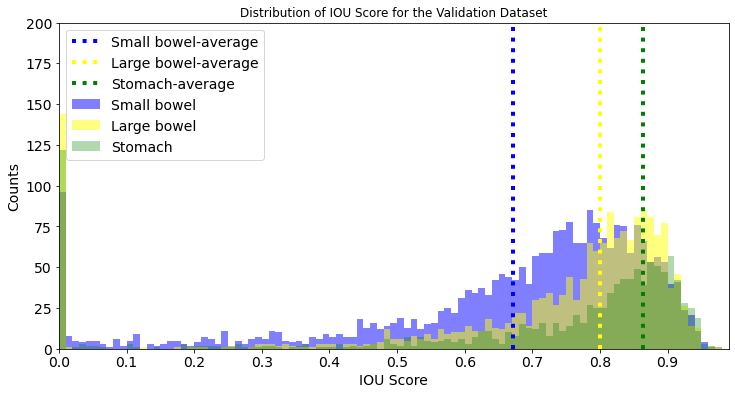

In [ ]:
# Distribution of IOU score for the validation set
plt.figure(figsize=(12,6))
plt.hist(iou_score_validation_smallbowel, alpha=0.5, label='Small bowel', color='blue', bins=100)
plt.axvline(avg_iou_validation[3], label='Small bowel-average', color='blue', linestyle='dotted', linewidth=4)
plt.hist(iou_score_validation_largebowel, label='Large bowel', color='yellow', bins=100, alpha=0.5)
plt.axvline(avg_iou_validation[2], label='Large bowel-average', color='yellow', linestyle='dotted', linewidth=4)
plt.hist(iou_score_validation_stomach, label='Stomach', color='green', bins=100, alpha=0.3)
plt.axvline(avg_iou_validation[1], label='Stomach-average', color='green', linestyle='dotted', linewidth=4)
plt.legend(fontsize=14)
plt.xlabel('IOU Score', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.xlim([0.0,0.99])
plt.ylim([0,200])
plt.yticks(fontsize=14)
plt.title('Distribution of IOU Score for the Validation Dataset')
plt.show()

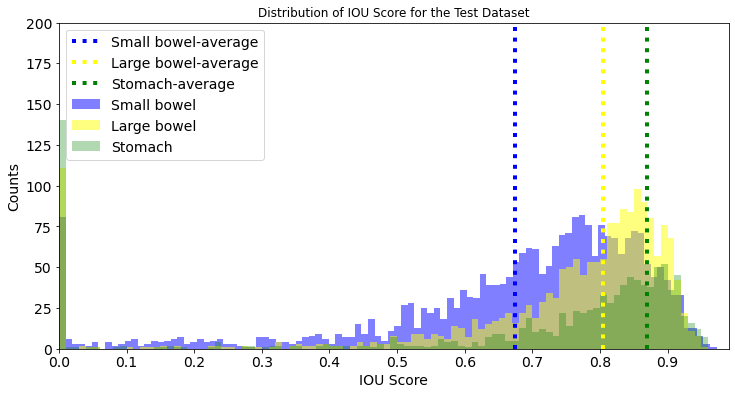

In [ ]:
# Distribution of test score for the validation set
plt.figure(figsize=(12,6))
plt.hist(iou_score_test_smallbowel, alpha=0.5, label='Small bowel', color='blue', bins=100)
plt.axvline(avg_iou_test[3], label='Small bowel-average', color='blue', linestyle='dotted', linewidth=4)
plt.hist(iou_score_test_largebowel, label='Large bowel', color='yellow', bins=100, alpha=0.5)
plt.axvline(avg_iou_test[2], label='Large bowel-average', color='yellow', linestyle='dotted', linewidth=4)
plt.hist(iou_score_test_stomach, label='Stomach', color='green', bins=100, alpha=0.3)
plt.axvline(avg_iou_test[1], label='Stomach-average', color='green', linestyle='dotted', linewidth=4)
plt.legend(fontsize=14)
plt.xlabel('IOU Score', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0.0,0.99])
plt.ylim([0,200])
plt.title('Distribution of IOU Score for the Test Dataset')
plt.show()

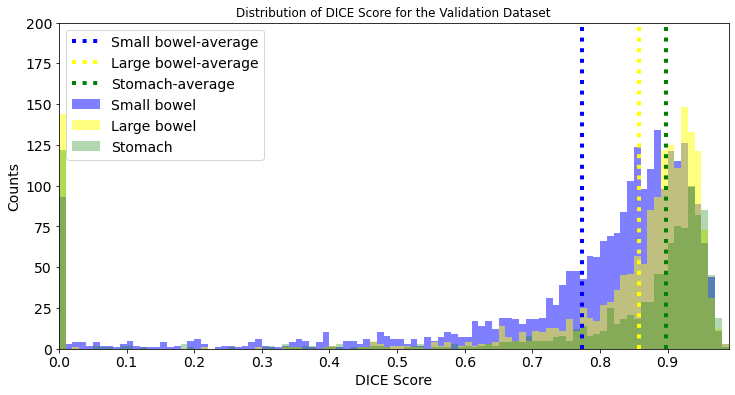

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(dice_score_validation_smallbowel, alpha=0.5, label='Small bowel', color='blue', bins=100)
plt.axvline(avg_dice_validation[3], label='Small bowel-average', color='blue', linestyle='dotted', linewidth=4)
plt.hist(dice_score_validation_largebowel, label='Large bowel', color='yellow', bins=100, alpha=0.5)
plt.axvline(avg_dice_validation[2], label='Large bowel-average', color='yellow', linestyle='dotted', linewidth=4)
plt.hist(dice_score_validation_stomach, label='Stomach', color='green', bins=100, alpha=0.3)
plt.axvline(avg_dice_validation[1], label='Stomach-average', color='green', linestyle='dotted', linewidth=4)
plt.legend(fontsize=14)
plt.xlabel('DICE Score', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.xlim([0.0,0.99])
plt.ylim([0,200])
plt.yticks(fontsize=14)
plt.title('Distribution of DICE Score for the Validation Dataset')
plt.show()

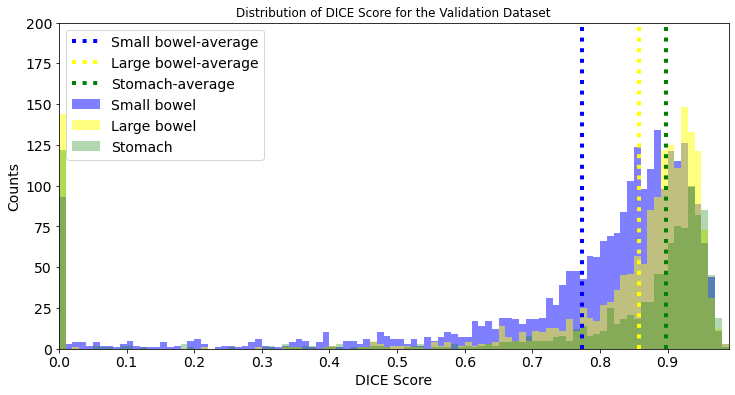

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(dice_score_validation_smallbowel, alpha=0.5, label='Small bowel', color='blue', bins=100)
plt.axvline(avg_dice_validation[3], label='Small bowel-average', color='blue', linestyle='dotted', linewidth=4)
plt.hist(dice_score_validation_largebowel, label='Large bowel', color='yellow', bins=100, alpha=0.5)
plt.axvline(avg_dice_validation[2], label='Large bowel-average', color='yellow', linestyle='dotted', linewidth=4)
plt.hist(dice_score_validation_stomach, label='Stomach', color='green', bins=100, alpha=0.3)
plt.axvline(avg_dice_validation[1], label='Stomach-average', color='green', linestyle='dotted', linewidth=4)
plt.legend(fontsize=14)
plt.xlabel('DICE Score', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.xlim([0.0,0.99])
plt.ylim([0,200])
plt.yticks(fontsize=14)
plt.title('Distribution of DICE Score for the Validation Dataset')
plt.show()

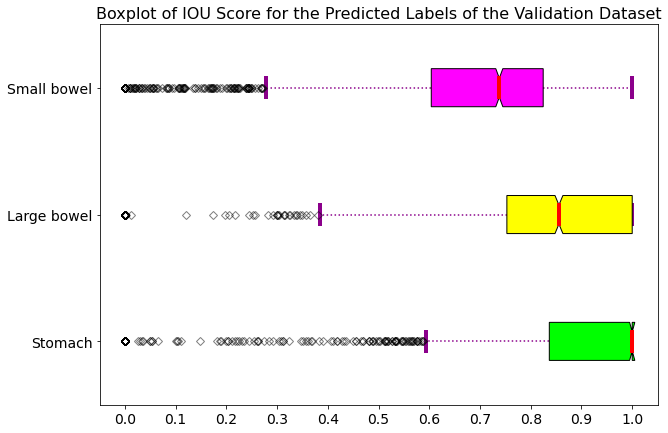

In [ ]:
# Create boxplot of IOU score for validation dataset
iou_score_validation_boxplot = list()
iou_score_validation_boxplot.append(iou_score_validation_stomach)
iou_score_validation_boxplot.append(iou_score_validation_largebowel)
iou_score_validation_boxplot.append(iou_score_validation_smallbowel)
x = ['Stomach', 'Large bowel', 'Small bowel']

fig = plt.figure(figsize=(10,7))
ax= fig.add_subplot(111)

bp = ax.boxplot(iou_score_validation_boxplot, vert=0, patch_artist=True, notch=True)

colors = ['#00FF00','#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")

for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 4)
 
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 4)
 
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
    
ax.set_yticklabels(x, fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.title('Boxplot of IOU Score for the Predicted Labels of the Validation Dataset', fontsize=16)

plt.show()

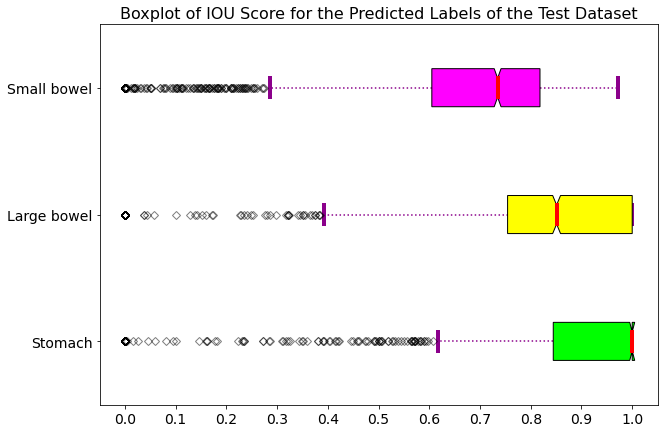

In [ ]:
# Create boxplot of IOU score for test dataset
iou_score_test_boxplot = list()
iou_score_test_boxplot.append(iou_score_test_stomach)
iou_score_test_boxplot.append(iou_score_test_largebowel)
iou_score_test_boxplot.append(iou_score_test_smallbowel)
x = ['Stomach', 'Large bowel', 'Small bowel']

fig = plt.figure(figsize=(10,7))
ax= fig.add_subplot(111)

bp = ax.boxplot(iou_score_test_boxplot, vert=0, patch_artist=True, notch=True)

colors = ['#00FF00','#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")

for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 4)
 
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 4)
 
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
    
ax.set_yticklabels(x, fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.title('Boxplot of IOU Score for the Predicted Labels of the Test Dataset', fontsize=16)

plt.show()

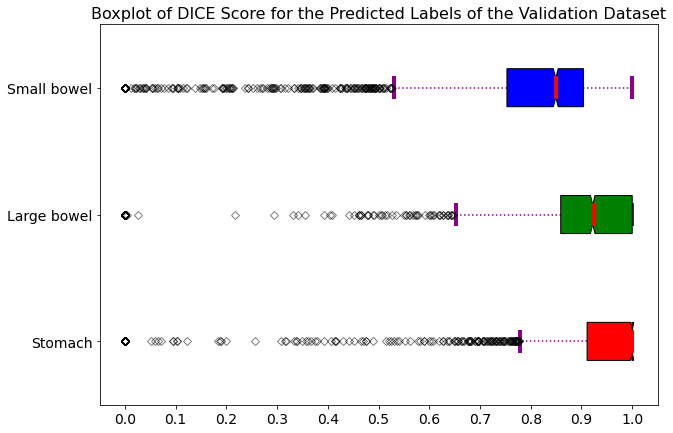

In [ ]:
# Create boxplot of DICE score for validation dataset
dice_score_validation_boxplot = list()
dice_score_validation_boxplot.append(dice_score_validation_stomach)
dice_score_validation_boxplot.append(dice_score_validation_largebowel)
dice_score_validation_boxplot.append(dice_score_validation_smallbowel)
x = ['Stomach', 'Large bowel', 'Small bowel']

fig = plt.figure(figsize=(10,7))
ax= fig.add_subplot(111)

bp = ax.boxplot(dice_score_validation_boxplot, vert=0, patch_artist=True, notch=True)

colors = ['red','green', 'blue']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")

for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 4)
 
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 4)
 
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
    
ax.set_yticklabels(x, fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.title('Boxplot of DICE Score for the Predicted Labels of the Validation Dataset', fontsize=16)

plt.show()

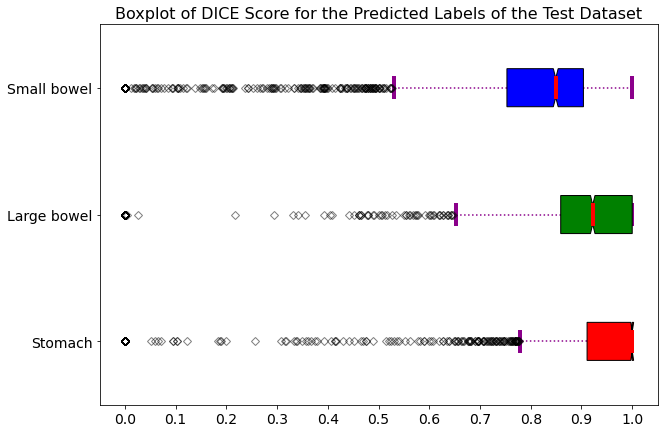

In [ ]:
# Create boxplot of DICE score for validation dataset
dice_score_test_boxplot = list()
dice_score_test_boxplot.append(dice_score_test_stomach)
dice_score_test_boxplot.append(dice_score_test_largebowel)
dice_score_test_boxplot.append(dice_score_test_smallbowel)
x = ['Stomach', 'Large bowel', 'Small bowel']

fig = plt.figure(figsize=(10,7))
ax= fig.add_subplot(111)

bp = ax.boxplot(dice_score_validation_boxplot, vert=0, patch_artist=True, notch=True)

colors = ['red','green', 'blue']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")

for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 4)
 
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 4)
 
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
    
ax.set_yticklabels(x, fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.title('Boxplot of DICE Score for the Predicted Labels of the Test Dataset', fontsize=16)

plt.show()

Let's plot some of the predictions with large IOU.

In [ ]:
large_iou_test_stomach = [iou_score_test_stomach.index(i) for i in iou_score_test_stomach if i > 0.9 and i!=1]
large_iou_test_smallbowel = [iou_score_test_smallbowel.index(i) for i in iou_score_test_smallbowel if i > 0.9 and i!=1]
large_iou_test_largebowel = [iou_score_test_largebowel.index(i) for i in iou_score_test_largebowel if i > 0.9 and i!=1]

### Predictions with large IOU scores

Large IOU score for "Stomach" label 



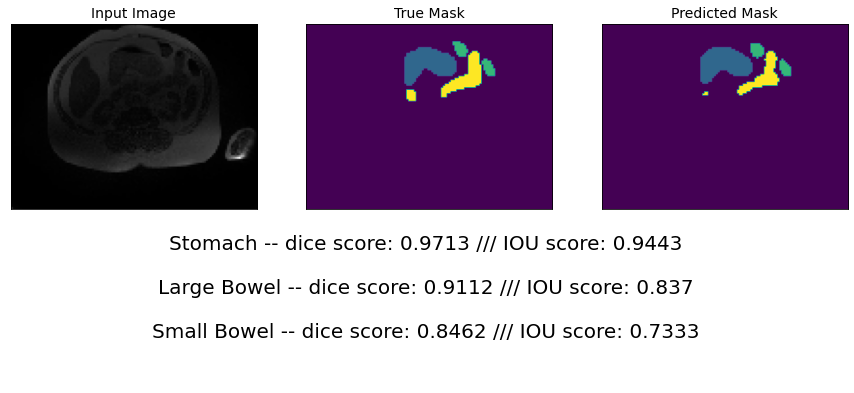

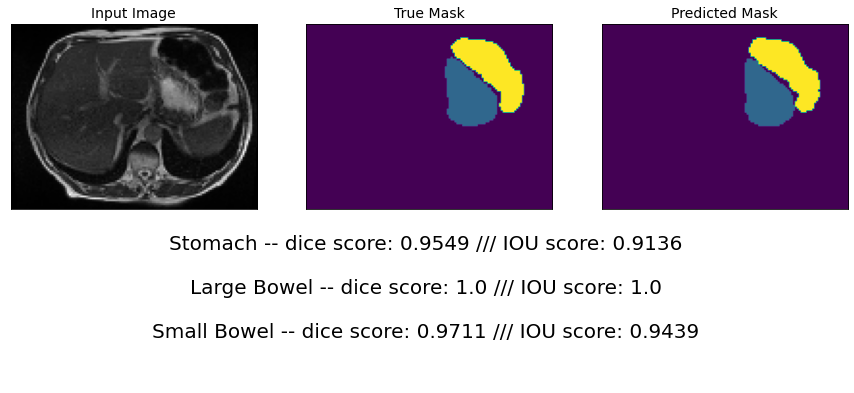

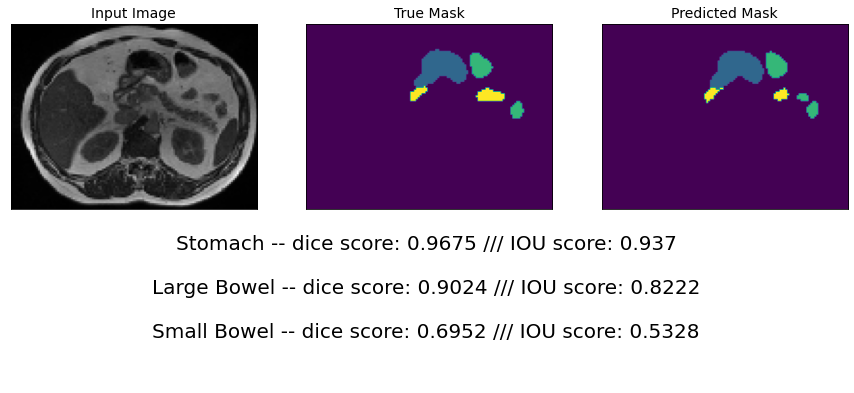

In [ ]:
print('Large IOU score for "Stomach" label \n')
display(test_processed_ds, large_iou_test_stomach[0]+1)
display(test_processed_ds, large_iou_test_stomach[1]+1)
display(test_processed_ds, large_iou_test_stomach[2]+1)

Large IOU score for "Large Bowel" label 



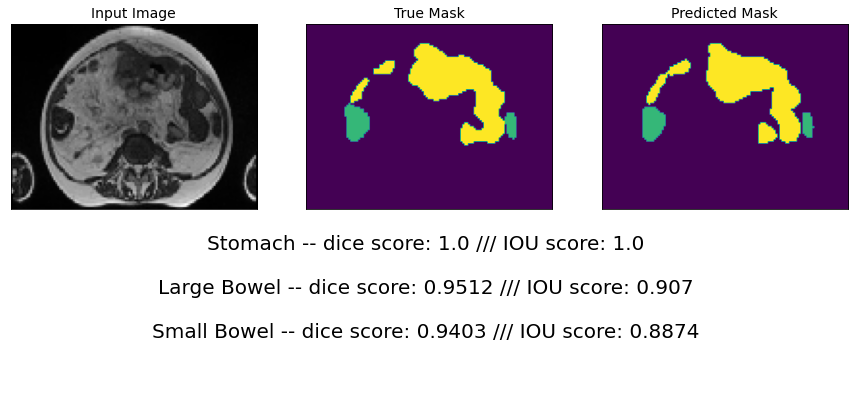

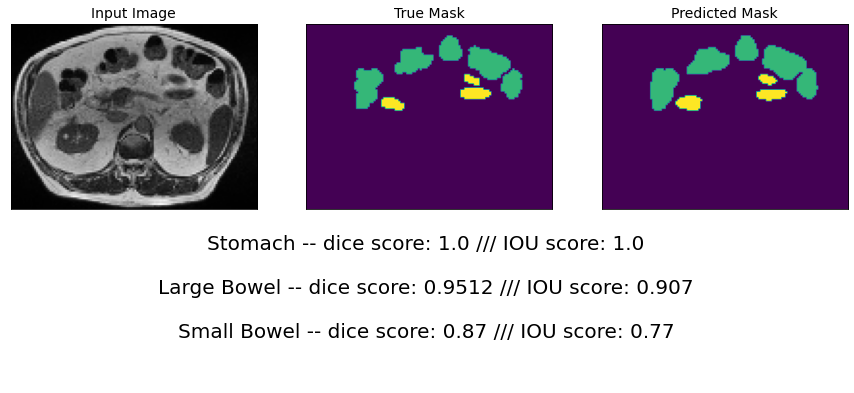

In [ ]:
print('Large IOU score for "Large Bowel" label \n')
display(test_processed_ds, large_iou_test_largebowel[0]+1)
display(test_processed_ds, large_iou_test_largebowel[1]+1)


Large IOU score for "Small Bowel" label 



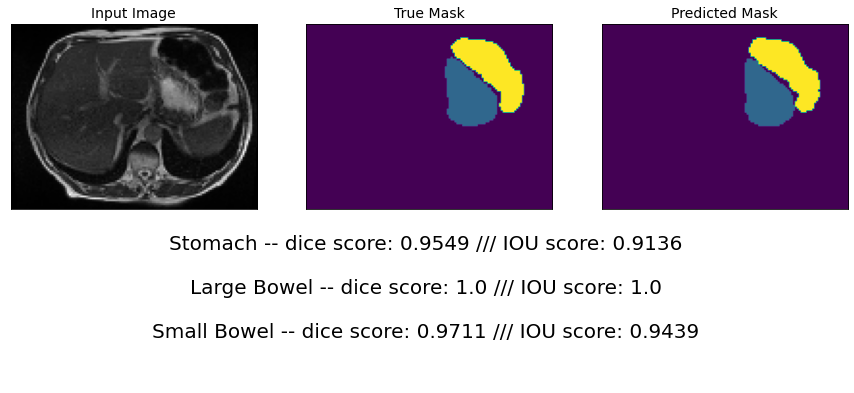

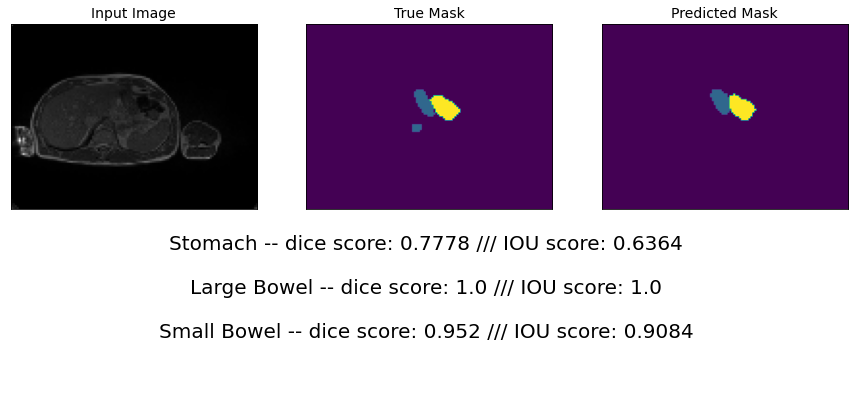

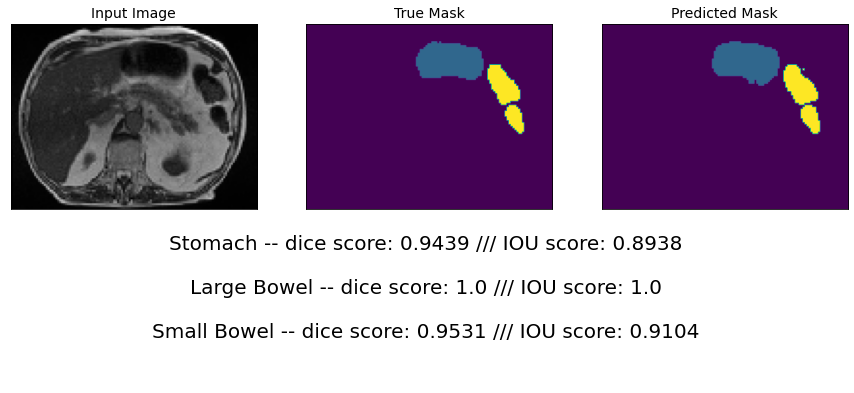

In [ ]:
print('Large IOU score for "Small Bowel" label \n')
display(test_processed_ds, large_iou_test_smallbowel[0]+1)
display(test_processed_ds, large_iou_test_smallbowel[1]+1)
display(test_processed_ds, large_iou_test_smallbowel[2]+1)

### Predictions with small IOU scores

In [ ]:
small_iou_test_stomach = [i for i in range(len(iou_score_test_stomach)) if iou_score_test_stomach[i]<0.001]
small_iou_test_smallbowel = [i for i in range(len(iou_score_test_smallbowel)) if iou_score_test_smallbowel[i]<0.001]
small_iou_test_largebowel = [i for i in range(len(iou_score_test_stomach)) if iou_score_test_largebowel[i]<0.001]

Small IOU score for "Stomach" label 



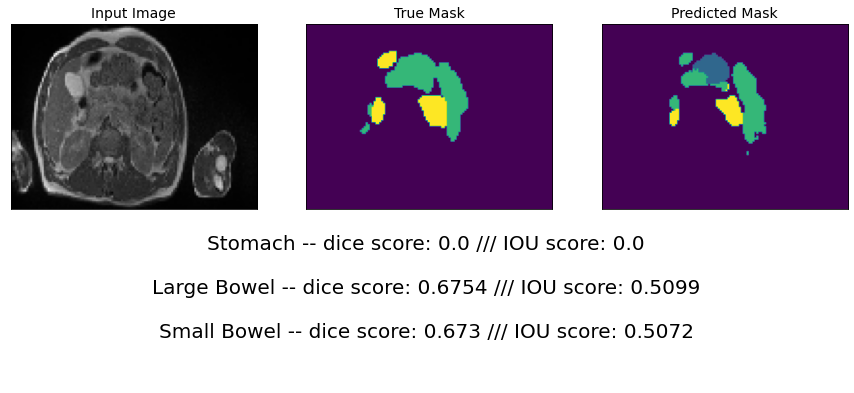

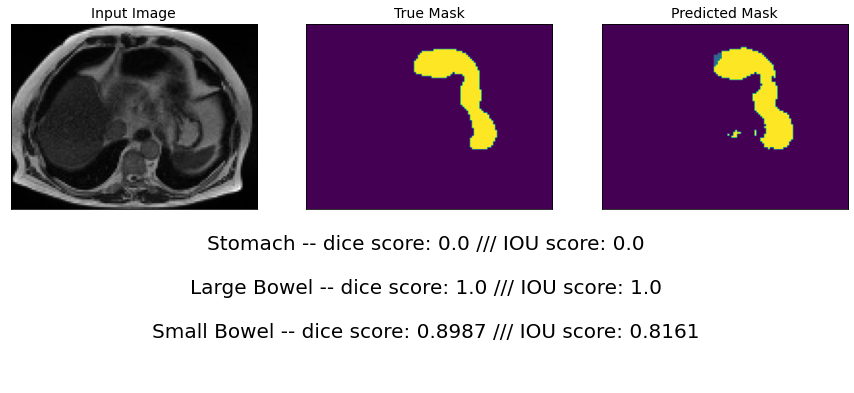

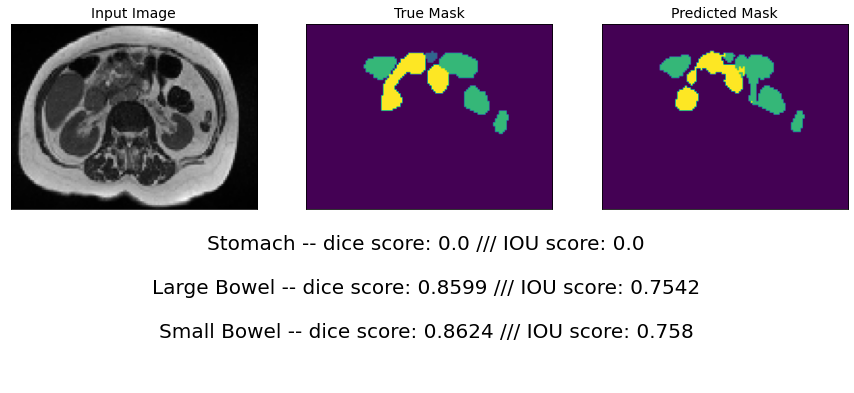

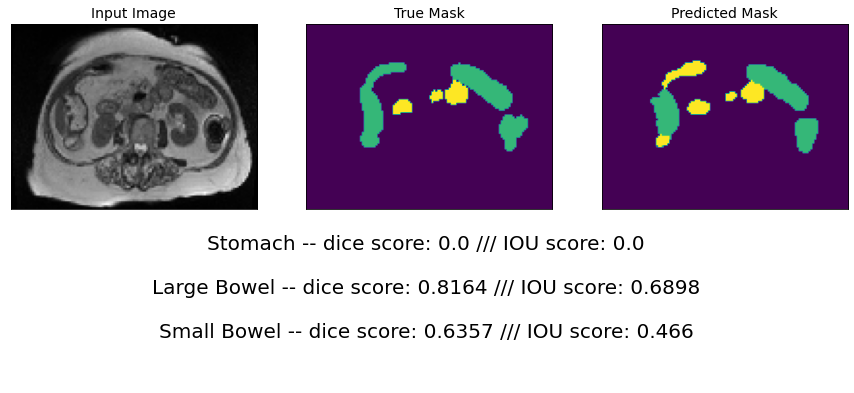

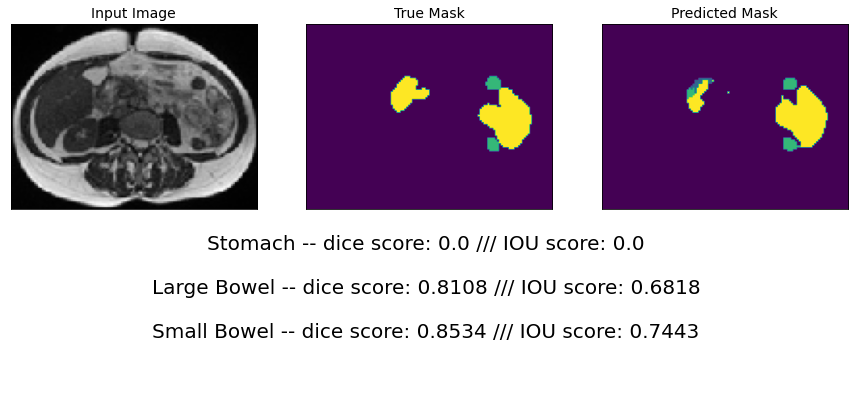

In [ ]:
print('Small IOU score for "Stomach" label \n')
display(test_processed_ds, small_iou_test_stomach[0]+1)
display(test_processed_ds, small_iou_test_stomach[1]+1)
display(test_processed_ds, small_iou_test_stomach[2]+1)
display(test_processed_ds, small_iou_test_stomach[3]+1)
display(test_processed_ds, small_iou_test_stomach[4]+1)

Small IOU score for "Small bowel" label 



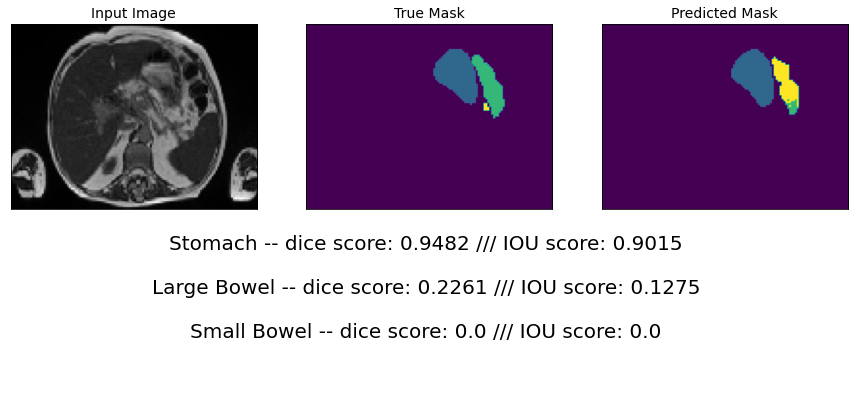

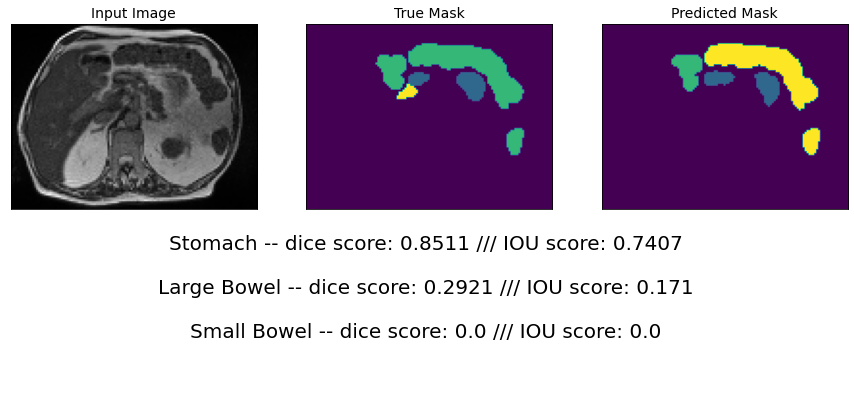

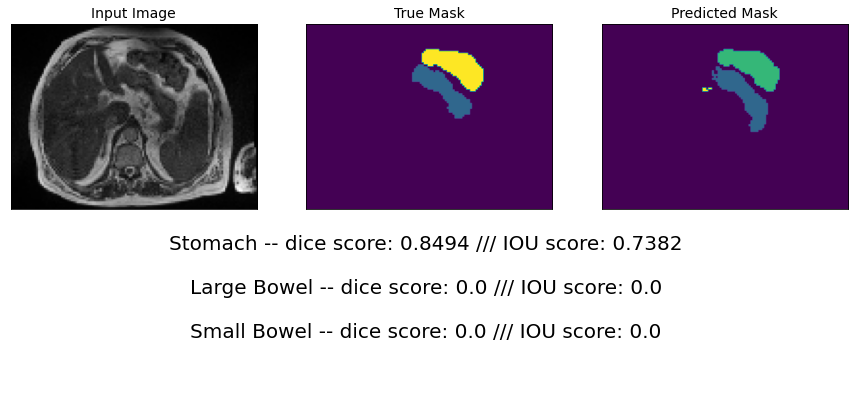

In [ ]:
print('Small IOU score for "Small bowel" label \n')
display(test_processed_ds, small_iou_test_smallbowel[10]+1)
display(test_processed_ds, small_iou_test_smallbowel[20]+1)
display(test_processed_ds, small_iou_test_smallbowel[30]+1)

Small IOU score for "Large bowel" label 



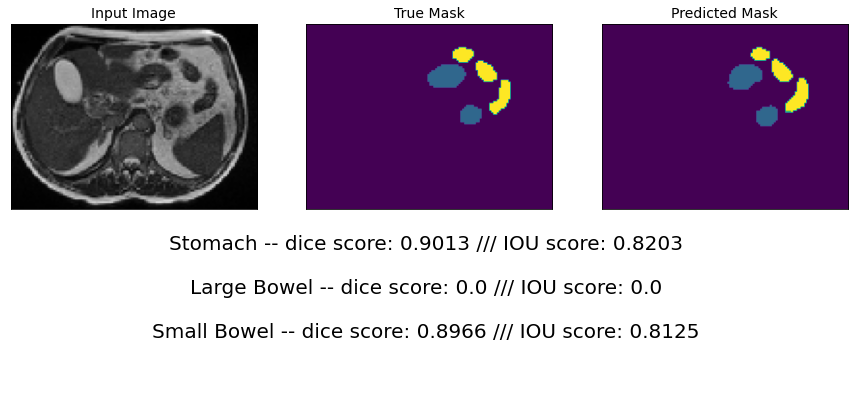

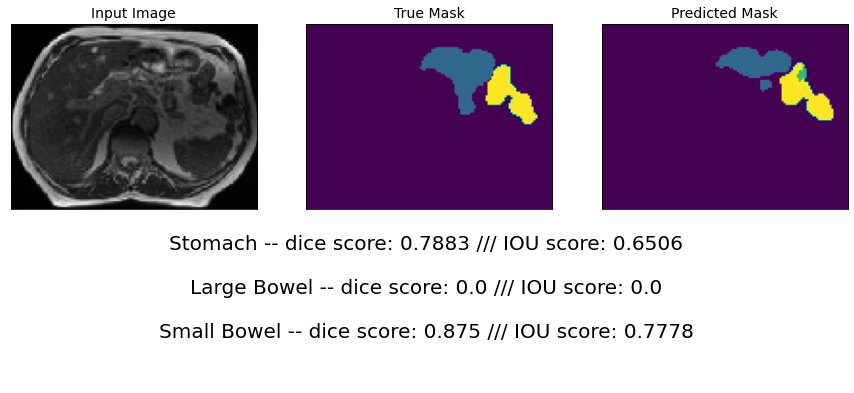

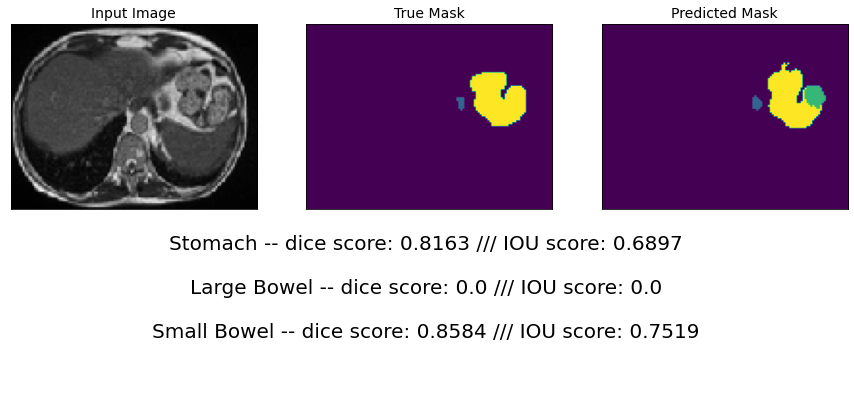

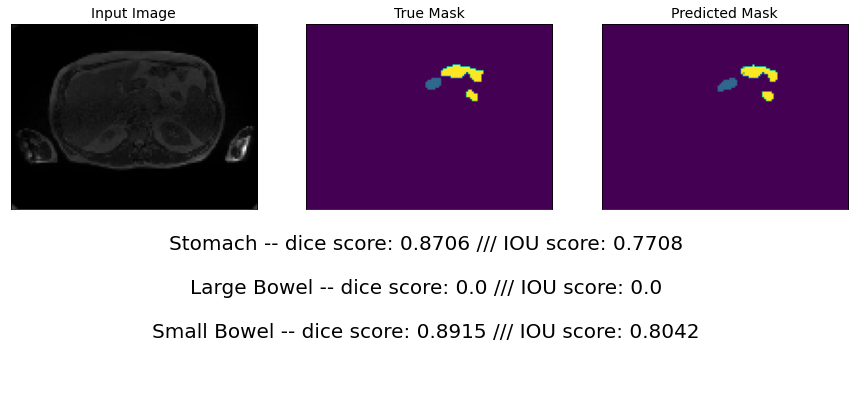

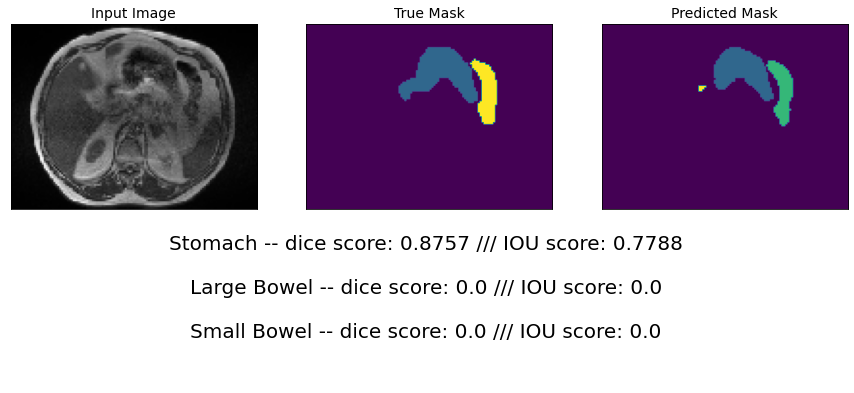

In [ ]:
print('Small IOU score for "Large bowel" label \n')
display(test_processed_ds, small_iou_test_largebowel[0]+1)
display(test_processed_ds, small_iou_test_largebowel[1]+1)
display(test_processed_ds, small_iou_test_largebowel[2]+1)
display(test_processed_ds, small_iou_test_largebowel[3]+1)
display(test_processed_ds, small_iou_test_largebowel[4]+1)

Small IOU score for "Large bowel" label 



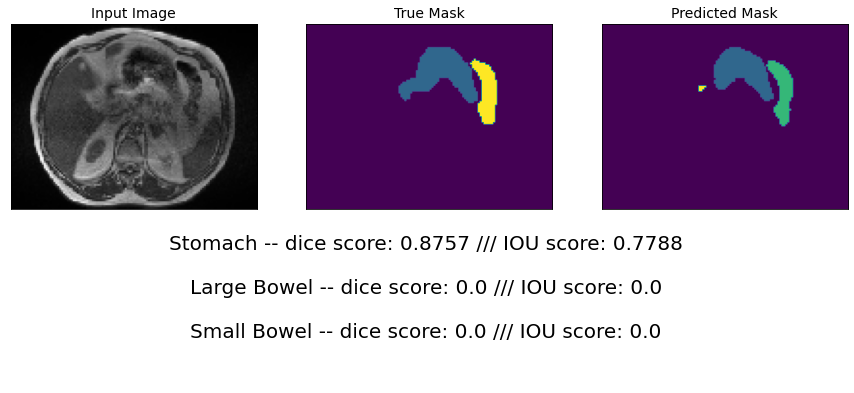

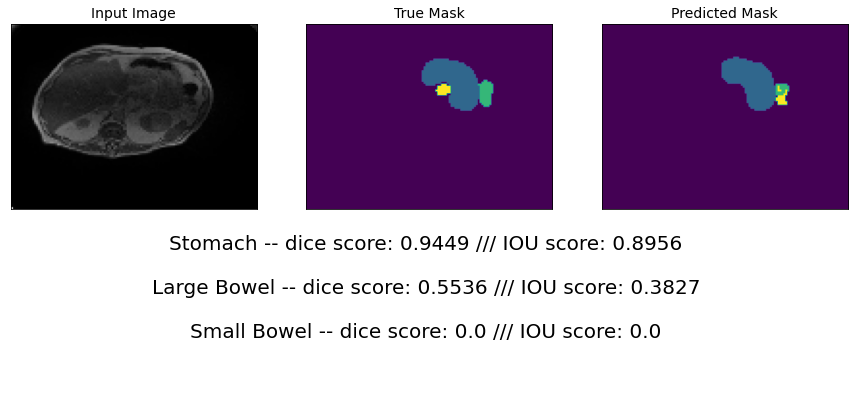

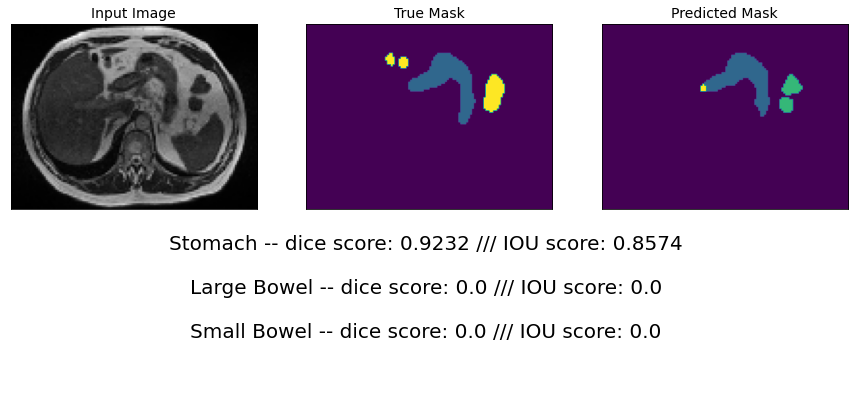

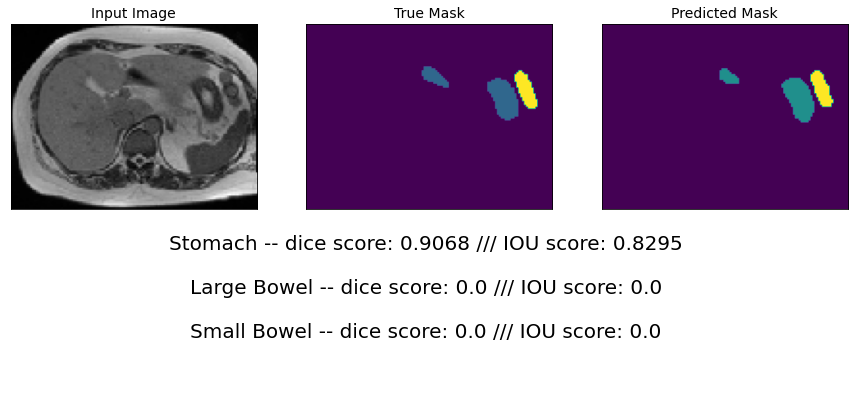

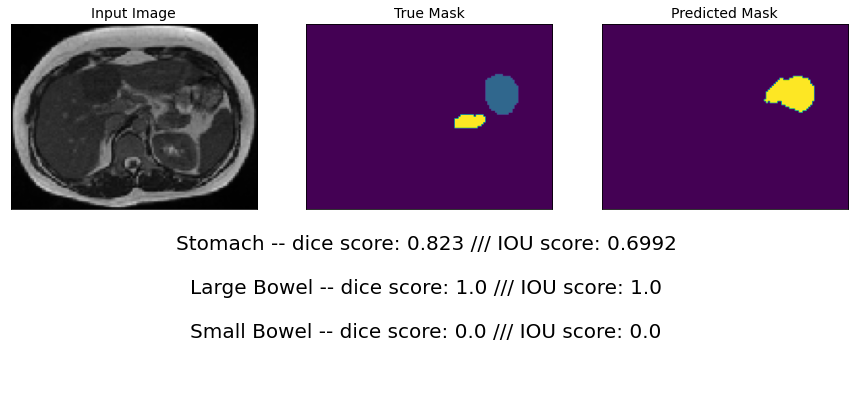

In [ ]:
print('Small IOU score for "Large bowel" label \n')
display(test_processed_ds, small_iou_test_smallbowel[0]+1)
display(test_processed_ds, small_iou_test_smallbowel[1]+1)
display(test_processed_ds, small_iou_test_smallbowel[2]+1)
display(test_processed_ds, small_iou_test_smallbowel[3]+1)
display(test_processed_ds, small_iou_test_smallbowel[4]+1)

### **Avergae Score of All Predicted Labels**

In [ ]:
# Calculate the average total IOU score

iou_score_test_avg = [np.average(iou_score_test[i]) for i in range(len(iou_score_test))]
iou_score_validation_avg = [np.average(iou_score_validation[i]) for i in range(len(iou_score_validation))]

dice_score_test_avg = [np.average(dice_score_test[i]) for i in range(len(dice_score_test))]
dice_score_validation_avg = [np.average(dice_score_validation[i]) for i in range(len(dice_score_validation))]

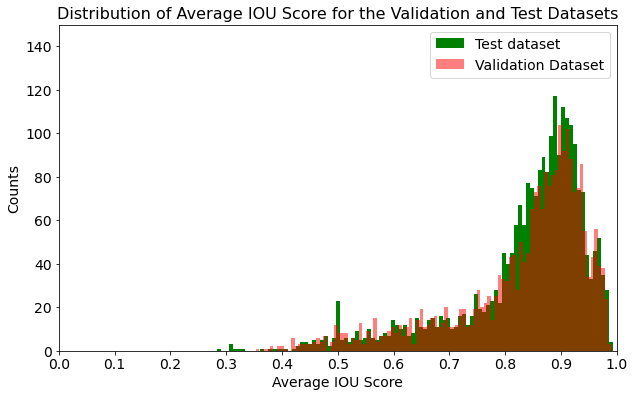

In [ ]:
# Plot the distribution of average IOU score for the validation and test datasets
plt.figure(figsize=(10,6))
plt.hist(iou_score_test_avg, bins=100, color='green', label='Test dataset')
plt.hist(iou_score_validation_avg, bins=100, color='red', label='Validation Dataset', alpha=0.5)
plt.legend(fontsize=14)
plt.xlabel('Average IOU Score', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.xlim([0.0,1])
plt.ylim([0,150])
plt.yticks(fontsize=14)
plt.title('Distribution of Average IOU Score for the Validation and Test Datasets', fontsize=16)
plt.show()

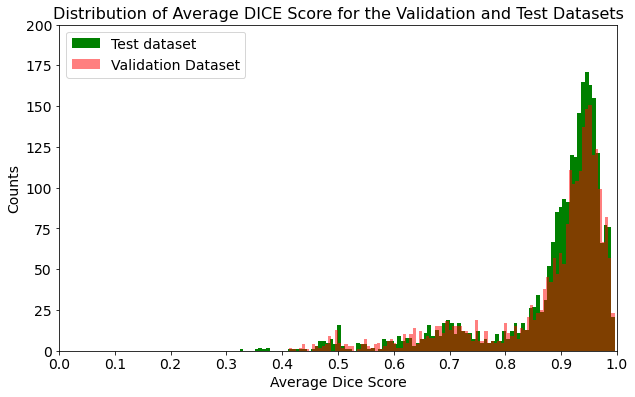

In [ ]:
# Plot the distribution of average Dice score for the validation and test datasets
plt.figure(figsize=(10,6))
plt.hist(dice_score_test_avg, bins=100, color='green', label='Test dataset')
plt.hist(dice_score_validation_avg, bins=100, color='red', label='Validation Dataset', alpha=0.5)
plt.legend(fontsize=14)
plt.xlabel('Average Dice Score', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(np.arange(0,1.1,0.1),fontsize=14)
plt.xlim([0.0,1])
plt.ylim([0,200])
plt.yticks(fontsize=14)
plt.title('Distribution of Average DICE Score for the Validation and Test Datasets', fontsize=16)
plt.show()

In [ ]:
# Plot some of the small and large score values

large_iou_score_test_avg = [i for i in range(len(iou_score_test_avg)) if iou_score_test_avg[i]>0.9]
small_iou_score_test_avg = [i for i in range(len(iou_score_test_avg)) if iou_score_test_avg[i]<0.4]


Small Average IOU score 



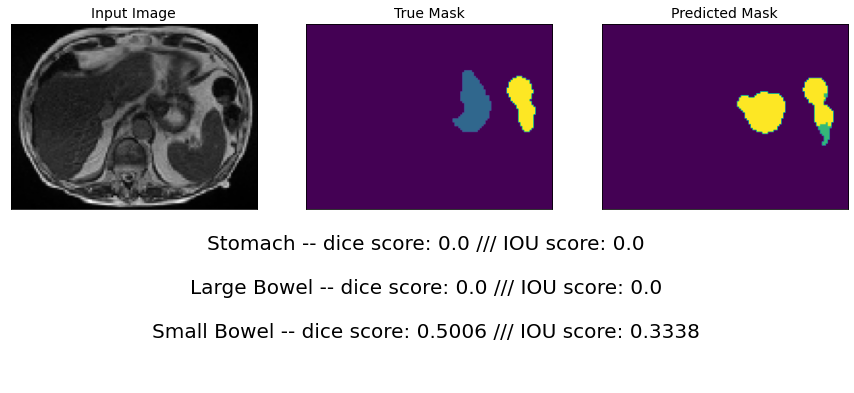

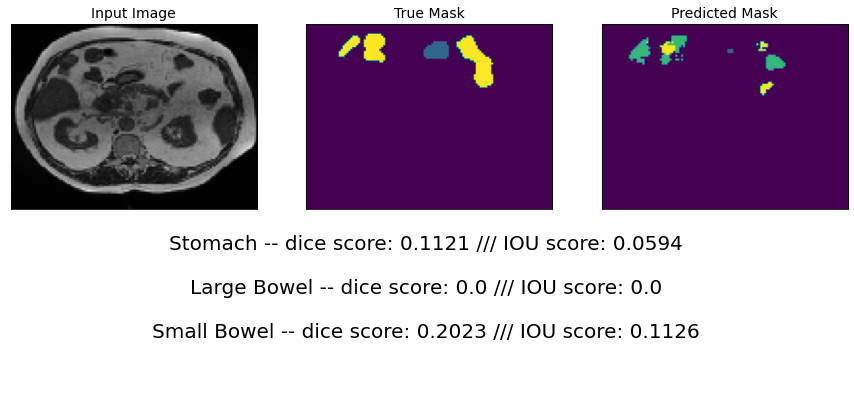

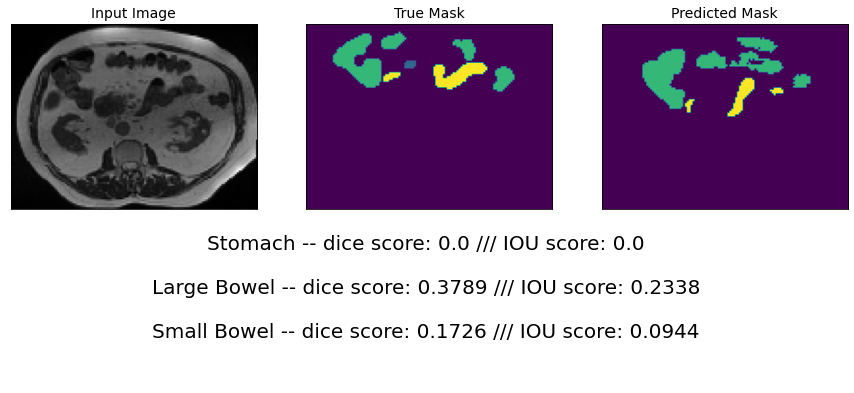

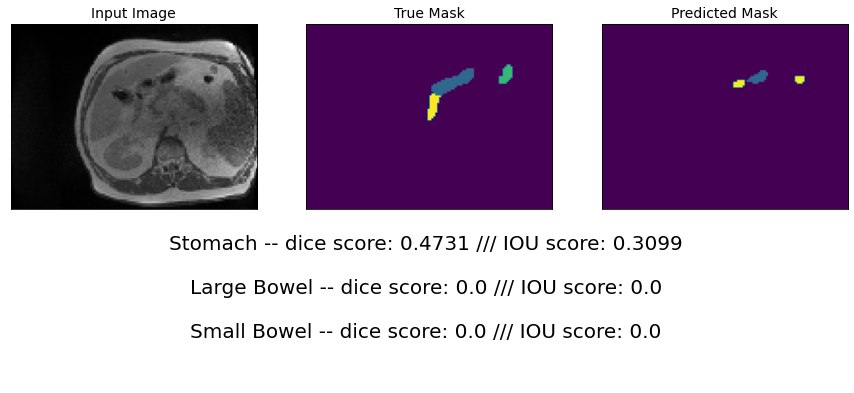

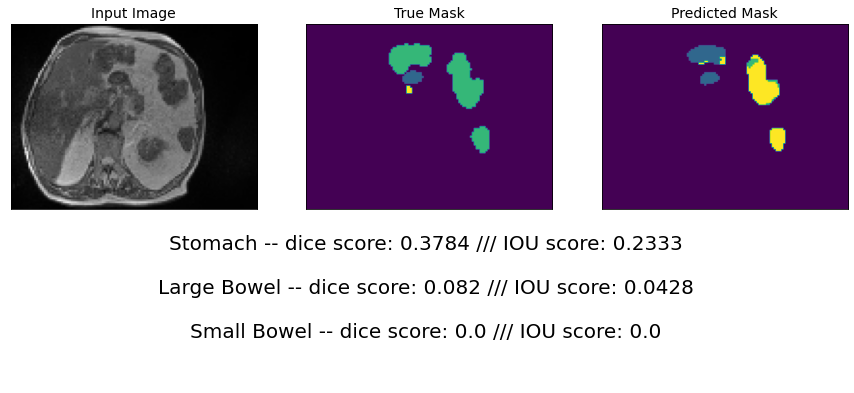

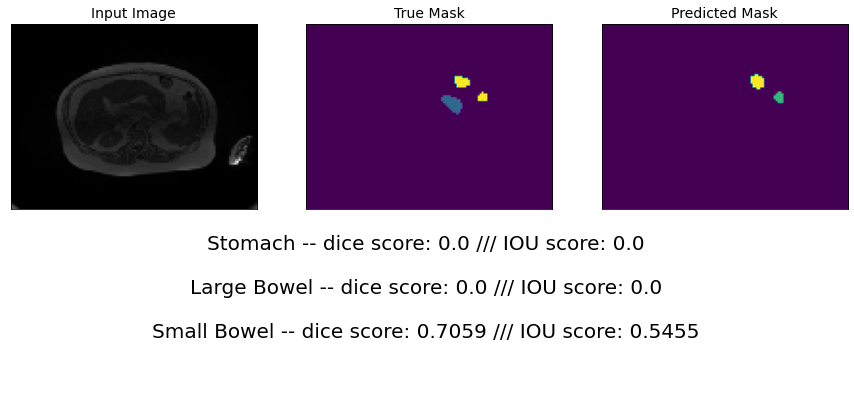

In [ ]:
print('Small Average IOU score \n')
display(test_processed_ds, small_iou_score_test_avg[0]+1)
display(test_processed_ds, small_iou_score_test_avg[1]+1)
display(test_processed_ds, small_iou_score_test_avg[2]+1)
display(test_processed_ds, small_iou_score_test_avg[3]+1)
display(test_processed_ds, small_iou_score_test_avg[4]+1)
display(test_processed_ds, small_iou_score_test_avg[5]+1)

Small Average IOU score 



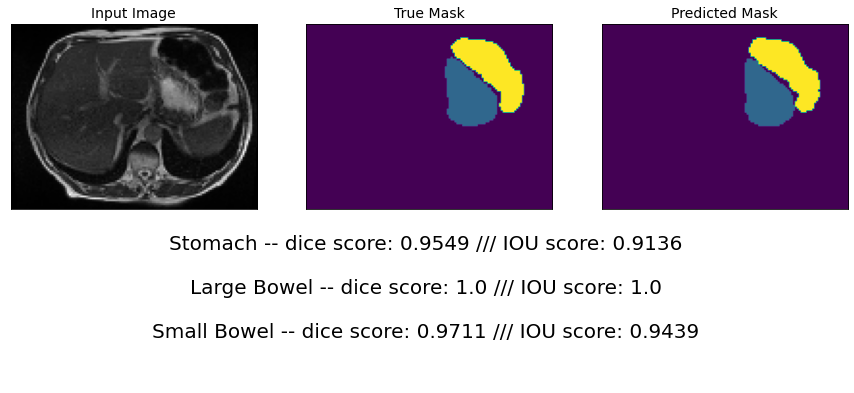

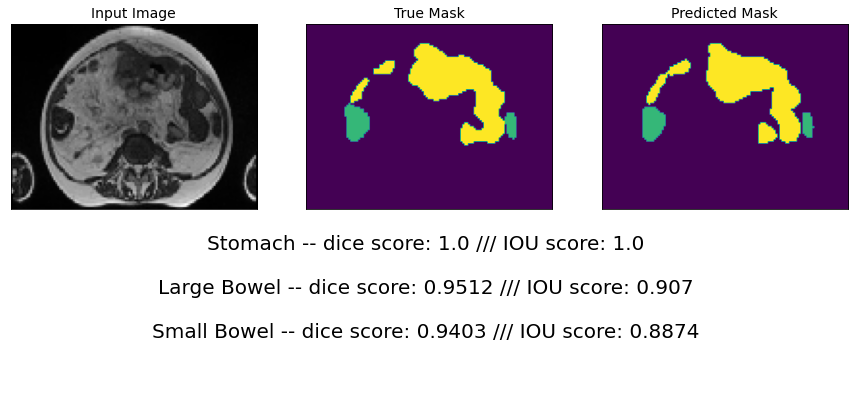

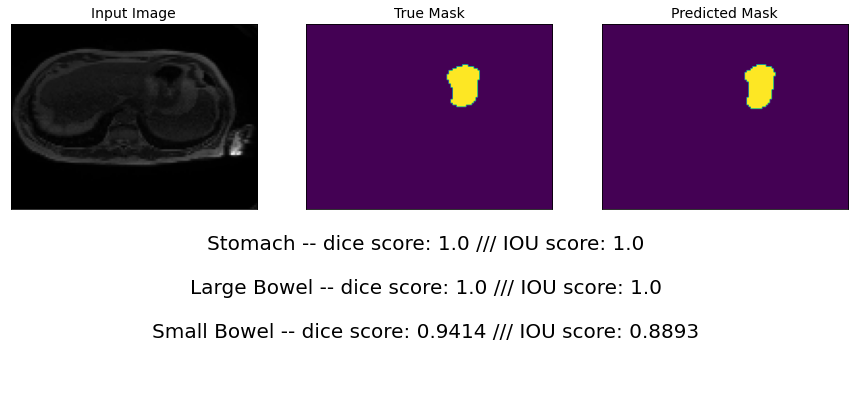

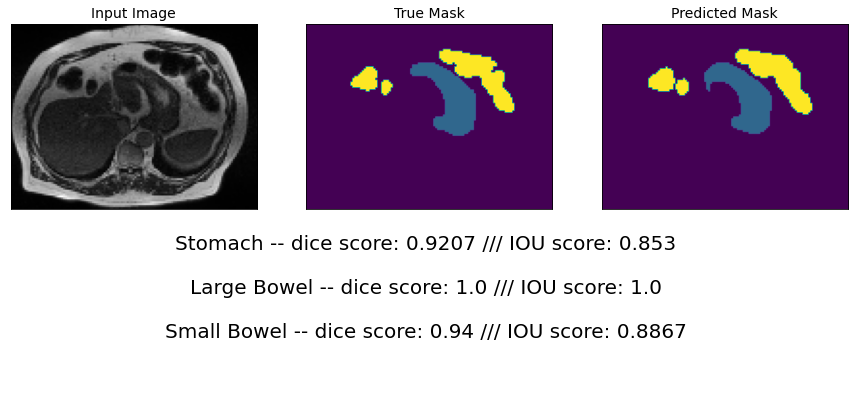

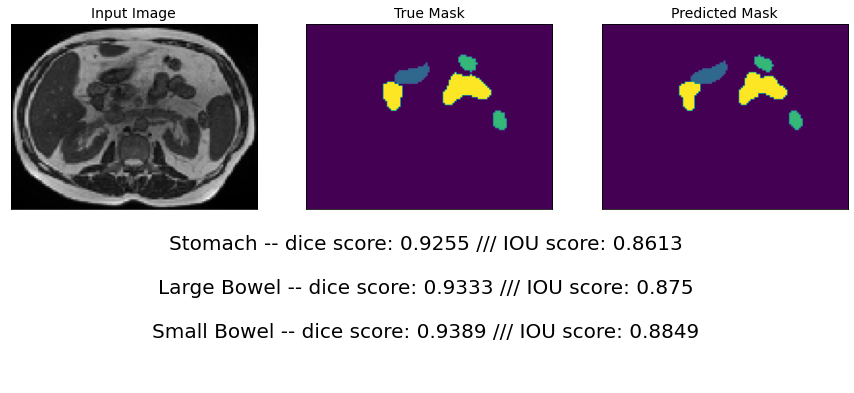

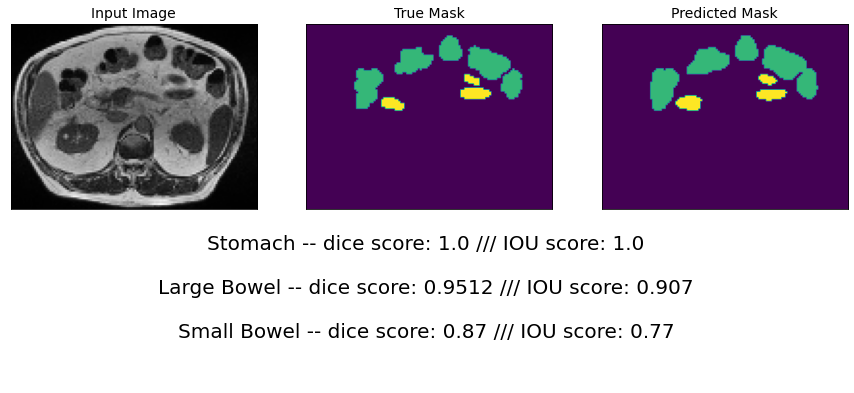

In [ ]:
print('Small Average IOU score \n')
display(test_processed_ds, large_iou_score_test_avg[0]+1)
display(test_processed_ds, large_iou_score_test_avg[1]+1)
display(test_processed_ds, large_iou_score_test_avg[2]+1)
display(test_processed_ds, large_iou_score_test_avg[3]+1)
display(test_processed_ds, large_iou_score_test_avg[4]+1)
display(test_processed_ds, large_iou_score_test_avg[5]+1)

## **Count Number of Scores Larger than 0.5 and 0.8**

In [ ]:
labels = ['background', 'stomach', 'large bowel', 'small bowel']
iou_5 = []

n = 0
for i in range(len(iou_score_test_background)):
  if iou_score_test_background[i] >= 0.5:
    n += 1
iou_5.append(n)

n = 0
for i in range(len(iou_score_test_stomach)):
  if iou_score_test_stomach[i] >= 0.5:
    n += 1
iou_5.append(n)

n = 0
for i in range(len(iou_score_test_largebowel)):
  if iou_score_test_largebowel[i] >= 0.5:
    n += 1
iou_5.append(n)

n = 0
for i in range(len(iou_score_test_smallbowel)):
  if iou_score_test_smallbowel[i] >= 0.5:
    n += 1
iou_5.append(n)

iou_5 = [i/len(iou_score_test) for i in iou_5]

In [ ]:
labels = ['background', 'stomach', 'large bowel', 'small bowel']
iou_8 = []

n = 0
for i in range(len(iou_score_test_background)):
  if iou_score_test_background[i] >= 0.8:
    n += 1
iou_8.append(n)

n = 0
for i in range(len(iou_score_test_stomach)):
  if iou_score_test_stomach[i] >= 0.8:
    n += 1
iou_8.append(n)

n = 0
for i in range(len(iou_score_test_largebowel)):
  if iou_score_test_largebowel[i] >= 0.8:
    n += 1
iou_8.append(n)

n = 0
for i in range(len(iou_score_test_smallbowel)):
  if iou_score_test_smallbowel[i] >= 0.8:
    n += 1
iou_8.append(n)

iou_8 = [i/len(iou_score_test) for i in iou_8]

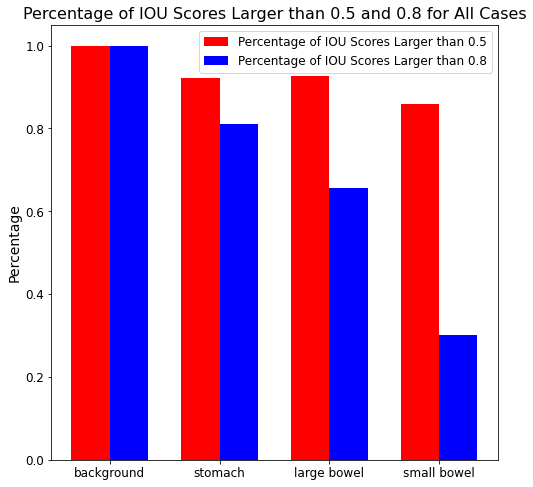

In [ ]:
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,8))
plt.bar(x - width/2, iou_5, width, label='Percentage of IOU Scores Larger than 0.5', color='r')
plt.bar(x + width/2, iou_8, width, label='Percentage of IOU Scores Larger than 0.8', color='b')

plt.ylabel('Percentage', fontsize=14)
plt.title('Percentage of IOU Scores Larger than 0.5 and 0.8 for All Cases', fontsize=16)
plt.xticks(x, labels, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()

In [ ]:
print(iou_5)

[1.0, 0.9208199356913184, 0.9264469453376206, 0.8581189710610932]


In [ ]:
print(iou_8)

[1.0, 0.8110932475884244, 0.655144694533762, 0.3022508038585209]
